# ISYE 6414 Regression Project – Modeling & Evaluation Code

This notebook contains the **full modeling workflow** for the project, starting from the cleaned state–year dataset and ending with cross-validated performance comparison across candidate models.

**What this code does:**
- Loads the cleaned **state–year panel (2011–2020)** built from College Scorecard, ACS, and FAFSA data.
- Fits a **baseline linear regression** for state-level weighted median graduate debt (`grad_debt_mdn_w`).
- Identifies and removes **influential observations** (Cook’s distance) and a small set of problematic states (NH, WV, WY) to define the final analysis dataset.
- Estimates a family of **interaction models** (e.g., net price × race/ethnicity, Pell share × FAFSA volume... etc) on the same cleaned data.
- Computes and compares **in-sample diagnostics** (residual plots, multicollinearity checks, influence measures).
- Implements **K-fold cross-validation** and a simple train/test split to evaluate predictive performance (MSE, MAE, MAPE, prediction mean ratio) for the key models (Model 3, 6, 9, 10).

The goal of this notebook is to provide a clear, reproducible record of how the final regression models were specified, checked, and evaluated for the project report.




The data ingestion, cleaning, and multi-source integration processes were completed as part of the team’s shared preprocessing pipeline. All relevant scripts for those steps are provided in the project repository root. The present notebook begins from the cleaned, integrated state-year dataset and contains only the individual modeling and analysis components associated with Approach 4.

## Approach #4 — Equity, Aid, and Debt
#### a) The approach
Assess whether aid generosity and demographic composition relate to debt, and whether aid mitigates price pressure.


**Response:** 

grad_debt_state

**Predictors:**

state_pell_share： Average Pell Grant recipient share,

state_net_price： Average Pell Grant recipient share,

pct_black：% Black (non-Hispanic)，

pct_hispanic： % Hispanic / Latino,

pct_white： % white,

pct_asian： % asian,

pct_male: %male,

median_hh_income_real： Median household income (real $),

pct_ba_plus： % with Bachelor's degree or higher,

pct_poverty_lt100： % below poverty line,

sector shares,

pct_25_34： % age 25–34;

year FE: Year Fixed Effects. Year fixed effects means that the regression includes a set of indicator (dummy) variables for each year in the dataset (2012, 2013, …, 2020),


Interaction (policy relevance): state_pell_share × state_net_price.

#### b) Success rationale:
Tests whether Pell intensity is associated with lower debt and whether it offsets high prices.

#### c) Anticipated challenges:
Collinearity among state_pell_share, pct_poverty_lt100, and race/ethnicity; interpret coefficients cautiously.

#### d) Alternatives
Quantile regression (heterogeneous effects across the debt distribution).

In [1]:
# Fix seed so results are exactly reproducible
set.seed(6414)

In [290]:
# --- Packages ---
suppressPackageStartupMessages({
library(here);
library(readr); 
library(dplyr); 
library(broom)
library(lmtest); 
library(sandwich); 
library(car)
library(ggplot2)
library(skimr)
library(tidyr)
library(maps)
library(ggthemes) 
library(caret)
})

In [291]:
# Read the data using read_csv
data_file <- here("data", "state_year_joined_2011_2020.csv")

df <- read.csv(data_file, header=TRUE)
head(df,5)

,state,year,log_grad_debt_state,grad_debt_mdn_w,state_net_price,state_pell_share,sector_public_share,sector_private_np_share,sector_forprofit_share,state_stem_share,⋯,pct_25_34,pct_poverty_lt100,pct_poverty_lt200,pct_enrolled_college,unemp_rate_acs,fafsa_apps_total,last_reported_quarter,expected_last_quarter,is_final_cycle,source_file
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>,<chr>
1,AK,2011,8.799771,6632.724,12349.709,0.2575172,0.8969899,0.01945061,0.08355950,0.1743621,⋯,14.30117,8.685783,24.84936,28.34330,7.989770,41438,Q6,Q6,TRUE,2011_2012_AppDatabyState_Q6.xls
2,AK,2012,8.839839,6903.881,12752.601,0.2602512,0.9160639,0.02140454,0.06253154,0.1523388,⋯,14.57411,9.677598,23.88763,28.07450,7.972325,41694,Q6,Q6,TRUE,2012_2013-App_Data_by_State_Q6.xls
3,AK,2013,8.929698,7552.985,9792.779,0.2764053,0.8815414,0.01685371,0.10160492,0.1527511,⋯,15.12326,7.262900,21.38823,27.24114,8.310207,41205,Q6,Q6,TRUE,2013_2014-App_Data_by_State_Q6.xls
4,AK,2014,9.023306,8294.156,11569.468,0.3150197,0.8353522,0.01484037,0.14980748,0.1503872,⋯,15.58863,10.709742,25.36465,27.14704,6.834544,38836,Q5,Q5,TRUE,2014_2015-App_Data_by_State_Q5.xls
5,AK,2015,9.118477,9122.299,11062.291,0.2804330,0.8843308,0.01549845,0.10017075,0.1475392,⋯,16.21366,8.638480,25.20968,26.10478,6.915765,38537,Q6,Q6,TRUE,2015_2016-App_Data_By_State_Q6.xls


In [292]:
dim(df)

[1] 510  30

In [293]:
colnames(df)

[1] "state"                   "year"                   
 [3] "log_grad_debt_state"     "grad_debt_mdn_w"        
 [5] "state_net_price"         "state_pell_share"       
 [7] "sector_public_share"     "sector_private_np_share"
 [9] "sector_forprofit_share"  "state_stem_share"       
[11] "ugds_total"              "median_hh_income_real"  
[13] "pct_ba_plus"             "pct_male"               
[15] "pct_female"              "pct_black"              
[17] "pct_hispanic"            "pct_white"              
[19] "pct_asian"               "pct_18_24"              
[21] "pct_25_34"               "pct_poverty_lt100"      
[23] "pct_poverty_lt200"       "pct_enrolled_college"   
[25] "unemp_rate_acs"          "fafsa_apps_total"       
[27] "last_reported_quarter"   "expected_last_quarter"  
[29] "is_final_cycle"          "source_file"

### 1. EDA:

Step 1: keep the useful vars. 

Step 2: simple summary stats (min, max, mean, sd) for the vars

Step 3: Correlation matrix for key numeric vars.

Step 4: choose the vars for my model

Step 5: Standardize the predictors use in the model

Step 6: baseline model, interaction model (Pell × price),
        Residual Analysis:
            residual plots & Q-Q plot.
            

**Simple summary table (min / mean / sd / max)**

In [294]:
# numeric variables for EDA (exclude state and year)
num_vars <- c(
                "grad_debt_mdn_w",
                "state_net_price",
                "state_pell_share",
                "sector_public_share",
                "sector_private_np_share",
                "sector_forprofit_share",
                "state_stem_share",
                "ugds_total",
                "median_hh_income_real",
                "pct_ba_plus",
                "pct_female",
                "pct_male",
                "pct_black",
                "pct_hispanic",
                "pct_white",
                "pct_asian",
                "pct_18_24",
                "pct_25_34",
                "pct_poverty_lt100",
                "pct_poverty_lt200",
                "pct_enrolled_college",
                "unemp_rate_acs",
                "fafsa_apps_total"
)
# Simple summary table: min / max / mean / sd for each variable
summ_stats <- t(
  sapply(df[num_vars], function(x) {
    x <- as.numeric(x)
    c(
      min  = min(x, na.rm = TRUE),
      max  = max(x, na.rm = TRUE),
      mean = mean(x, na.rm = TRUE),
      sd   = sd(x,   na.rm = TRUE)
    )
  })
)

summ_stats


,min,max,mean,sd
grad_debt_mdn_w,5.934247e+03,1.775599e+04,1.149645e+04,2.361227e+03
state_net_price,7.960640e+03,3.720223e+04,1.460036e+04,4.150792e+03
state_pell_share,1.985790e-01,5.692541e-01,3.539049e-01,6.244178e-02
sector_public_share,6.429658e-02,9.959230e-01,7.294553e-01,1.591131e-01
sector_private_np_share,0.000000e+00,8.107264e-01,1.931196e-01,1.561518e-01
sector_forprofit_share,2.116356e-03,5.483314e-01,7.742510e-02,7.916600e-02
state_stem_share,7.943958e-02,2.265810e-01,1.419487e-01,2.717128e-02
ugds_total,1.684300e+04,2.413020e+06,3.074817e+05,3.781173e+05
median_hh_income_real,4.415094e+04,9.938710e+04,6.471848e+04,1.129890e+04
pct_ba_plus,1.368805e+01,5.112793e+01,2.245036e+01,5.382657e+00


From the simple summary table (min / mean / sd / max), we can see that:

* Variables are on very different scales → supports standardization later.

* No missing or impossible values.

* Ranges appear reasonable for state-level data.

Key observations:

|Variable|	Interpretation|
|--------|----------------|
|grad_debt_mdn_w (5934 → 17,755)|	Wide variability; suggests high inequality in debt across states.|
|state_net_price (7,906 → 37,202)|	Major variation; strong predictor of debt.|
|state_pell_share (0.19 → 0.56)|	Large differences in aid intensity.|
|sector shares	|Correctly range between 0–1.|
|ugds_total (16k → 2.4M)|	Very large scale → will need log or standardization if used.|
|median_hh_income_real (41k → 99k)|	Large income variation across states.|
|pct_ba_plus (13.7 → 51.1%)|	Different education compositions.|
|pct_asian(0.005\% → 4.38\%)|Extreme Low Minimum, While technically possible for a small population group, this value is extremely close to zero and is several standard deviations below the mean (0.78%).|
|pct_white, pct_black, pct_hispanic| show very large ranges (Min to Max), which is expected because of the enormous demographic differences between US states|	no anomalies.|
|pct_poverty_lt100\lt200 |show strong variation|	may create multicollinearity.|
|fafsa_apps_total ~250k → 2.6M|	Big range; needs scaling if added to models.|


For the pct_asian Anomalous Nature, for a state-year aggregate, seeing a value this close to zero for any large racial group is rare. This low minimum suggests that either:

The population of Asian persons in that specific state-year was genuinely negligible (a true minimum).

There might be a data limitation in the original ACS microdata or the aggregation process for a specific state, potentially misrepresenting a low-population state.

**Correlation matrix for key numeric variables**

In [295]:
# restrict to numeric columns only
eda_numeric <- df %>%
  dplyr::select(all_of(num_vars)) %>%
  dplyr::select(where(is.numeric))

cor_mat <- cor(eda_numeric, use = "pairwise.complete.obs")
cor_mat

,grad_debt_mdn_w,state_net_price,state_pell_share,sector_public_share,sector_private_np_share,sector_forprofit_share,state_stem_share,ugds_total,median_hh_income_real,pct_ba_plus,⋯,pct_hispanic,pct_white,pct_asian,pct_18_24,pct_25_34,pct_poverty_lt100,pct_poverty_lt200,pct_enrolled_college,unemp_rate_acs,fafsa_apps_total
grad_debt_mdn_w,1.00000000,0.69884027,-0.37318652,-0.40910388,0.52587636,-0.215026177,0.50346673,-0.15962732,0.24836251,0.571195491,⋯,-0.33779421,0.03600438,-0.02910180,-0.51021218,0.17701481,-0.31886013,-0.42235913,-0.584326528,-0.41005156,-0.165469450
state_net_price,0.69884027,1.00000000,-0.27194742,-0.74844158,0.80583543,-0.085210932,0.16194604,-0.14695255,0.47601299,0.741916082,⋯,-0.24190293,0.04221268,0.04737145,-0.44900591,0.31710184,-0.40344528,-0.53464803,-0.457100887,-0.19225398,-0.176371857
state_pell_share,-0.37318652,-0.27194742,1.00000000,0.06830015,-0.19806783,0.253406778,-0.42720324,0.21528317,-0.54574493,-0.415383756,⋯,0.11777204,-0.11197672,-0.13482705,0.19786758,-0.27299727,0.71500487,0.72000111,0.267971447,0.53278211,0.270912213
sector_public_share,-0.40910388,-0.74844158,0.06830015,1.00000000,-0.87405341,-0.285830628,0.20535468,0.06037864,-0.31659864,-0.572632547,⋯,0.12712001,-0.02312258,-0.08011311,0.24583099,-0.37980760,0.14561427,0.25694977,0.236335997,-0.02811973,0.111521061
sector_private_np_share,0.52587636,0.80583543,-0.19806783,-0.87405341,1.00000000,-0.215729862,-0.03126528,-0.11464178,0.37545155,0.633427151,⋯,-0.22431157,0.01827308,0.11328457,-0.26442985,0.36627298,-0.27409810,-0.37278414,-0.236219432,-0.11463060,-0.142606611
sector_forprofit_share,-0.21502618,-0.08521093,0.25340678,-0.28583063,-0.21572986,1.000000000,-0.35106594,0.10477338,-0.10424237,-0.098495082,⋯,0.18695147,0.01043038,-0.06243269,0.02748999,0.04090357,0.24798244,0.21886727,-0.009070295,0.28262123,0.057143466
state_stem_share,0.50346673,0.16194604,-0.42720324,0.20535468,-0.03126528,-0.351065938,1.00000000,-0.17835232,0.13576469,0.180154006,⋯,-0.30623514,0.15945383,-0.11554693,-0.19247823,-0.01816344,-0.33269593,-0.32699185,-0.292971735,-0.48623177,-0.177638286
ugds_total,-0.15962732,-0.14695255,0.21528317,0.06037864,-0.11464178,0.104773378,-0.17835232,1.00000000,0.07594387,0.013757947,⋯,0.54498779,-0.19945209,0.50575925,0.14318073,0.05794618,0.13933157,0.12997254,0.244086085,0.20759353,0.984389802
median_hh_income_real,0.24836251,0.47601299,-0.54574493,-0.31659864,0.37545155,-0.104242371,0.13576469,0.07594387,1.00000000,0.774872952,⋯,0.15142114,-0.34820009,0.55132261,-0.25612935,0.46978158,-0.74127184,-0.86020296,-0.042285530,-0.22017083,0.039422716
pct_ba_plus,0.57119549,0.74191608,-0.41538376,-0.57263255,0.63342715,-0.098495082,0.18015401,0.01375795,0.77487295,1.000000000,⋯,0.07050616,-0.28697158,0.36959953,-0.44589212,0.58489534,-0.49724438,-0.66249192,-0.330788238,-0.16992090,-0.007567665


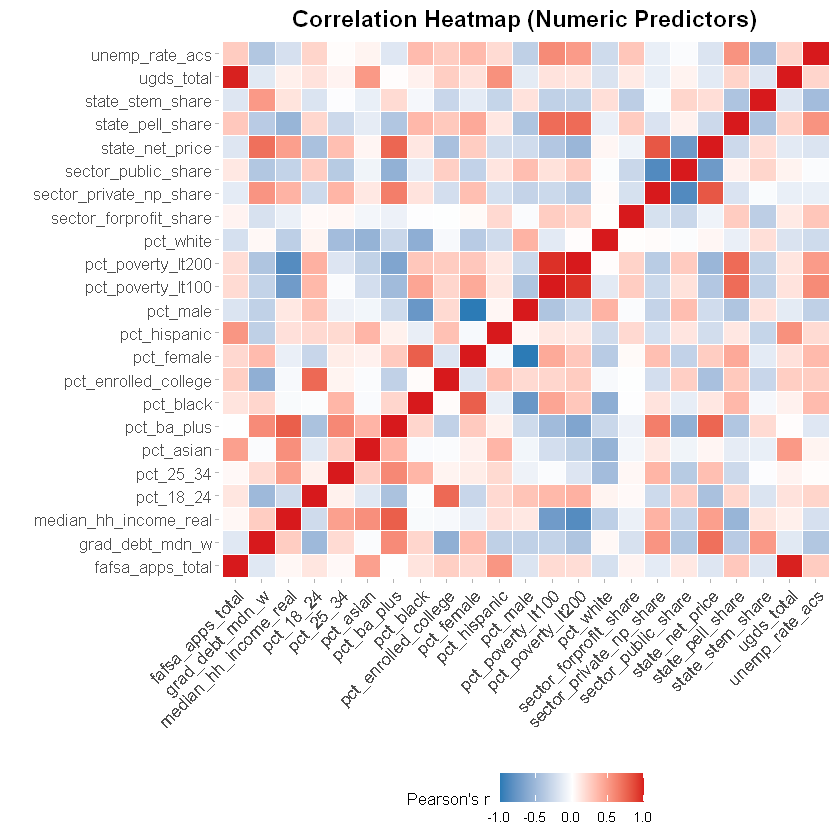

In [296]:
# Correlation plot
cor_long <- as.data.frame(cor_mat) %>%
  mutate(var1 = rownames(cor_mat)) %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")

ggplot(cor_long, aes(var1, var2, fill = corr)) +
  # 1. Tile Geometry: Use a color scale that is visually distinct
  geom_tile(color = "white", lwd = 0.5, linetype = 1) +
  
  # 2. Value Text: Add correlation value on the tile
  # Format to 2 decimal places and use a distinct text color
  # geom_text(aes(label = round(corr, 2)), size = 3, color = "black") + 
  
  # 3. Color Scale: Use a professional gradient
  scale_fill_gradient2(
    low = "#2C7BB6",       # Deep Blue for strong negative
    mid = "white",         # White for near-zero
    high = "#D7191C",      # Deep Red for strong positive
    midpoint = 0,
    limits = c(-1, 1),
    name = "Pearson's r"
  ) +
  
  # 4. Labels and Title
  labs(
    title = "Correlation Heatmap (Numeric Predictors)",
    x = "", 
    y = ""
  ) +
  
  # 5. Theme and Formatting
  theme_light(base_size = 10) +
  theme(
    # Axis Text: Rotate x-axis labels, increase size
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    
    # Title: Bold and center the title
    plot.title = element_text(face = "bold", hjust = 0.5, size = 14),
    
    # Grid/Panel: Remove panel grid and border
    panel.grid.major = element_blank(),
    panel.border = element_blank(),
    
    # Legend: Place the legend on the bottom
    legend.position = "bottom"
  )

 **Strong Positive Correlations ($r > 0.70$)**
 
 These relationships indicate that as one variable increases, the other tends to increase significantly.
 
|Correlated Variables|Correlation (r)|Context|
|--------------------|---------------|-------|
|FAFSA apps total vs. ugds_total|$+0.984$|State size measures (total applications vs. total undergraduate students) are nearly identical.|
|pct_poverty_lt100 vs. pct_poverty_lt200|$+0.947$|Two similar poverty measures (below 100% vs. below 200% of the poverty line) move in near-perfect sync.|
|state_net_price vs. pct_ba_plus|$+0.742$|States with higher college costs (net price) tend to have a more highly educated population.|
|median_hh_income_real vs. pct_ba_plus|$+0.775$|Higher income states are strongly associated with higher levels of educational attainment.|
|state_net_price vs. sector_private_np_share|$+0.806$|States with a higher share of enrollment in private non-profit institutions tend to have higher net prices.|
|pct_enrolled_college vs. pct_18_24|$+0.729$|College enrollment rates are strongly driven by the size of the traditional college-age population.|



**Strong Negative Correlations ($r < -0.70$)**

These relationships indicate that as one variable increases, the other tends to decrease significantly.

|Correlated Variables|Correlation (r)|Context|
|--------------------|---------------|-------|
|median_hh_income_real vs. pct_poverty_lt200|$-0.860$|Higher real median household income is strongly associated with a lower share of the population living below 200% of the poverty line.|
|median_hh_income_real vs. pct_poverty_lt100|$-0.741$|Higher income is strongly associated with a lower share of the population living below 100% of the poverty line.|
|sector_public_share vs. sector_private_np_share|$-0.874$|These are shares of the total student population; when public share is high, the private non-profit share must be low.|
|sector_public_share vs. state_net_price|$-0.748$|States where the public sector dominates enrollment tend to have lower average net prices.|


**Response by race**

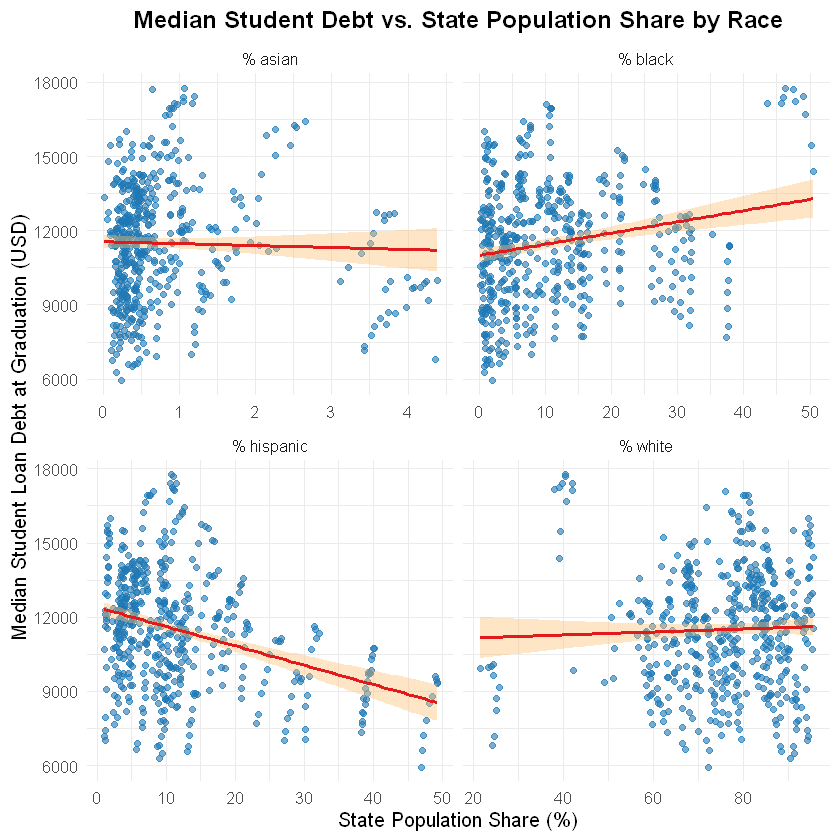

In [239]:
# scatter plot for response vs race
library(ggplot2)
library(tidyr)
library(dplyr)

#
# 1. Prepare data: Select the debt variable and the non-standardized race percentages
race_debt_data <- df %>%
  select(
    state,
    grad_debt_mdn_w,
    pct_black,
    pct_hispanic,
    pct_white,
    pct_asian
  ) %>%
  # Convert race shares to long format for easier plotting
  pivot_longer(
    cols = starts_with("pct_"),
    names_to = "Race_Group",
    values_to = "Population_Share"
  ) %>%
  # Clean up Race_Group labels
  mutate(
    Race_Group = gsub("pct_", "% ", Race_Group)
  )

# 2. Create Scatter Plots: Debt vs. State Racial Composition
ggplot(race_debt_data, aes(x = Population_Share, y = grad_debt_mdn_w)) +
  geom_point(alpha = 0.6, color = "#1f78b4") + # Use points for each state-year observation
  geom_smooth(method = "lm", formula = y ~ x ,se = TRUE, color = "#e31a1c", fill = "#fdbf6f") + # Add a linear trend line with confidence interval
  facet_wrap(~ Race_Group, scales = "free_x", ncol = 2) + # Separate plots for each race
  labs(
    title = "Median Student Debt vs. State Population Share by Race",
    x = "State Population Share (%)",
    y = "Median Student Loan Debt at Graduation (USD)"
  ) +
  theme_minimal(base_size = 12) +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

The scatter plots reveal modest national-level associations between state racial composition and student loan debt: states with larger Black population shares tend to report slightly higher median debt, while those with larger Hispanic shares show lower average debt. Asian and White shares display comparatively weak relationships. Because racial percentages in the dataset do not sum to 100% and exclude several groups, these results capture separate marginal correlations, not a complete demographic structure. Additionally, these correlations pool all states and years and therefore should not be interpreted as causal or as evidence of state-specific demographic effects.

**State-Level Race-Debt Correlations**

In [240]:
library(dplyr)

race_cor_by_state <- df %>%
  group_by(state) %>%
  summarise(
    cor_debt_black    = cor(grad_debt_mdn_w, pct_black,    use = "complete.obs"),
    cor_debt_hispanic = cor(grad_debt_mdn_w, pct_hispanic, use = "complete.obs"),
    cor_debt_white    = cor(grad_debt_mdn_w, pct_white,    use = "complete.obs"),
    cor_debt_asian    = cor(grad_debt_mdn_w, pct_asian,    use = "complete.obs"),
    .groups = "drop"
  )

# race_cor_by_state


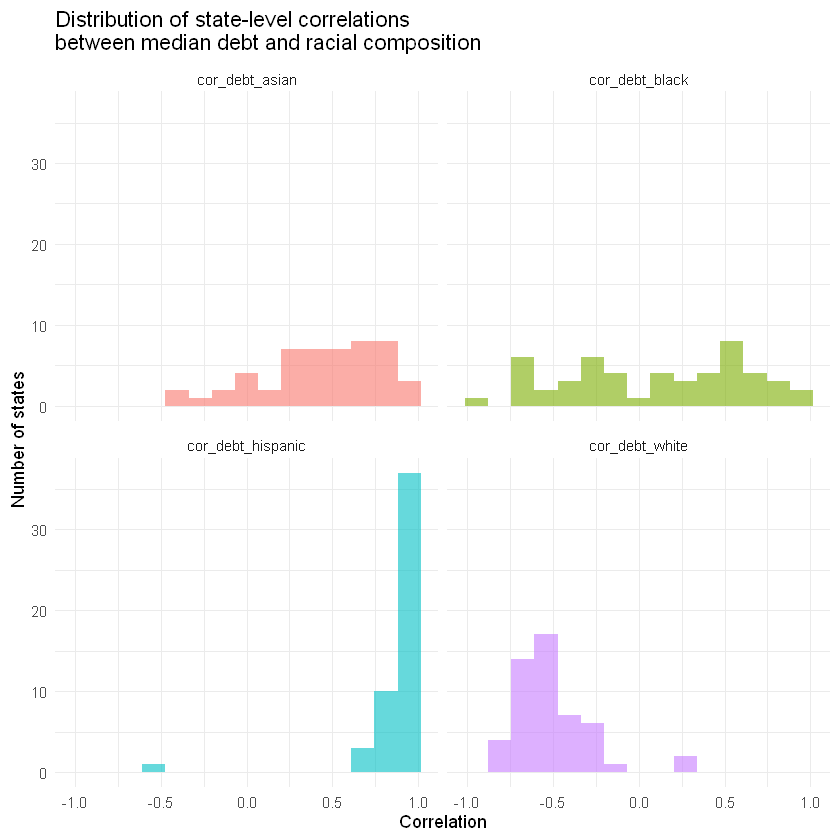

In [241]:
library(tidyr)
library(ggplot2)

race_cor_long <- race_cor_by_state %>%
  pivot_longer(
    cols = starts_with("cor_debt_"),
    names_to = "race",
    values_to = "correlation"
  )

ggplot(race_cor_long, aes(x = correlation, fill = race)) +
  geom_histogram(alpha = 0.6, bins = 15, position = "identity") +
  facet_wrap(~ race, ncol = 2) +
  labs(
    title = "Distribution of state-level correlations\nbetween median debt and racial composition",
    x = "Correlation",
    y = "Number of states"
  ) +
  theme_minimal(base_size = 11) +
  theme(legend.position = "none")


The analysis of state-level correlation histograms reveals the varying degree of consistency in how different racial groups' population shares relate to median student debt across states.
|Racial| GroupDistribution Center/Range|Relationship Consistency|
|------|-------------------------------|------------------------|
|% Asian|Mixed (centered around $+0.0$ to $+0.5$)|Highly Variable: The correlation is mixed and highly variable across states, ranging from negative to positive.|
|% Black|Highly Spread Out (centered slightly positive)|Highly Variable: The relationship is state-dependent. While the national average shows a positive effect (around $+\$400$ to $+\$500$ change in debt for a 1 SD increase), the plot shows many states with weak or negative correlation, balanced by a substantial number of states with a strong positive correlation.|
|% Hispanic|Heavily concentrated negative ($r \approx -0.5$ to $-1.0$)|Highly Consistent: A higher Hispanic population share is strongly and consistently associated with lower median student debt in the vast majority of states.|
|% White|Primarily concentrated negative ($r \approx -0.25$ to $-0.5$)|Moderately Consistent: A higher White population share tends to have a moderate association with lower median student debt in most states.|

This illustrates the heterogeneity of the race-debt relationship, showing that the negative effect of % Hispanic and the generally negative effect of % White are far more reliable at the state level than the effects of % Black and % Asian.

**Response by state distribution**

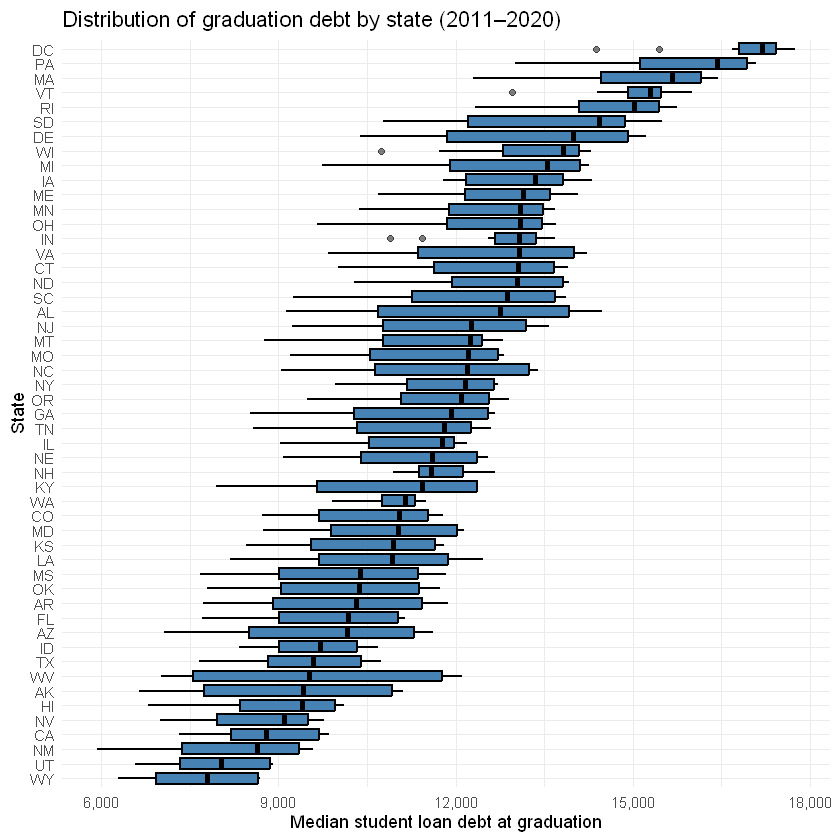

In [242]:
# Boxplot of response by state (visual distribution)
ggplot(df, aes(
  x = reorder(state, grad_debt_mdn_w, FUN = median),
  y = grad_debt_mdn_w
)) +
    geom_boxplot(
    outlier.alpha = 0.5, 
    fill = "#4682B4",           
    color = "black",            
    lwd = 0.8,                  
  ) +
  scale_y_continuous(labels = scales::comma)+ 
  coord_flip() +
  labs(
    x = "State",
    y = "Median student loan debt at graduation",
    title = "Distribution of graduation debt by state (2011–2020)"
  ) +
  theme_minimal(base_size = 11)

Across states, median graduation debt ranges from roughly \\$7.8k in Wyoming up to about \\$17.2k in the District of Columbia, with Pennsylvania and Massachusetts also in the highest-debt group. At the low end, Wyoming, Utah, and New Mexico form the lowest-debt cluster, all with medians below \\$9k. This represents nearly a two-fold difference between the lowest- and highest-debt states.

This wide cross-state variation in graduation debt—spanning from about \\$8k to \\$17k—motivates the regression analysis. The model examines how differences in **price (net price)**, **aid intensity (Pell share)**, **demographic composition**, and **socioeconomic factors** help explain why some states systematically exhibit higher or lower debt burdens at graduation.


**Response by year distribution**

In [243]:
# Numeric summary of grad_debt_mdn_w by year
library(dplyr)

resp_by_year <- df %>%
  group_by(year) %>%
  summarise(
    n_obs   = n(),
    min_debt = min(grad_debt_mdn_w, na.rm = TRUE),
    q1_debt  = quantile(grad_debt_mdn_w, 0.25, na.rm = TRUE),
    median_debt = median(grad_debt_mdn_w, na.rm = TRUE),
    mean_debt   = mean(grad_debt_mdn_w, na.rm = TRUE),
    q3_debt  = quantile(grad_debt_mdn_w, 0.75, na.rm = TRUE),
    max_debt = max(grad_debt_mdn_w, na.rm = TRUE),
    sd_debt  = sd(grad_debt_mdn_w, na.rm = TRUE)
  ) %>%
  arrange(year)

resp_by_year

year,n_obs,min_debt,q1_debt,median_debt,mean_debt,q3_debt,max_debt,sd_debt
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2011,51,5934.247,7759.331,9074.583,9240.286,10326.95,14380.53,1895.207
2012,51,6501.294,8182.515,9741.567,9822.690,10892.47,15446.91,2088.156
2013,51,6757.767,8888.139,10478.553,10520.394,11742.63,16689.34,2156.615
2014,51,7462.023,9438.317,11107.423,11084.934,12313.53,17422.02,2161.087
2015,51,7755.514,10017.836,11654.201,11656.726,12869.75,17226.84,2152.164
2016,51,7822.281,10662.781,12231.806,12182.598,13574.38,17702.25,2188.479
2017,51,8660.026,11402.601,12544.134,12609.415,13727.38,17755.99,1956.410
2018,51,8658.015,11441.823,12468.125,12603.974,13857.74,17410.72,1941.639
2019,51,8628.282,11429.448,12547.421,12592.782,13873.47,17137.81,1951.131


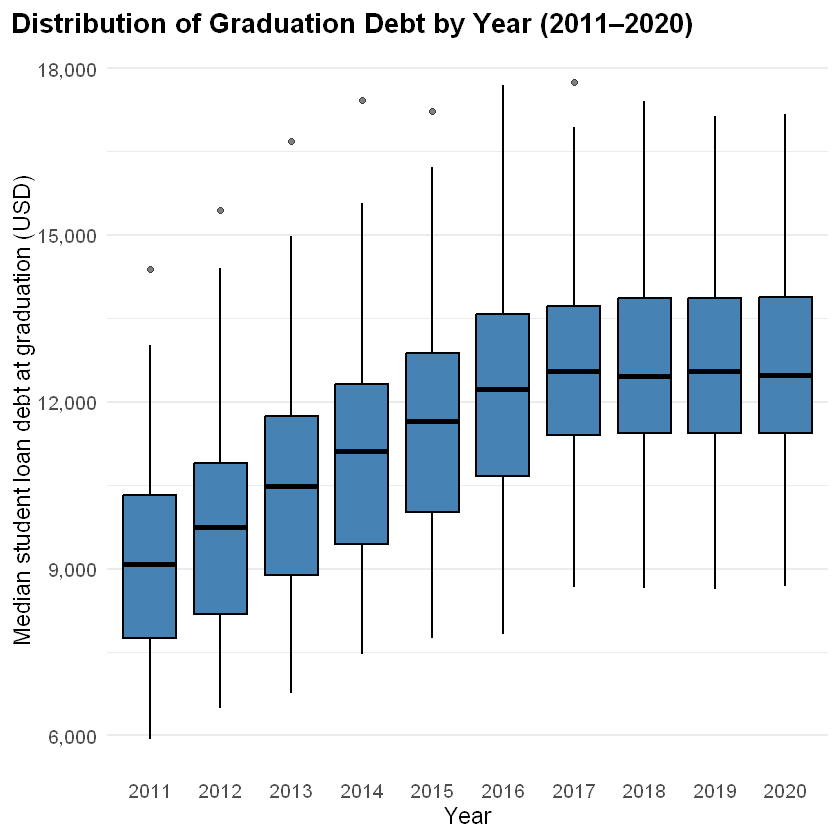

In [244]:
ggplot(df, aes(
  x = factor(year),          # <-- make year discrete
  y = grad_debt_mdn_w
)) +
  geom_boxplot(
    outlier.alpha = 0.5,
    fill = "#4682B4",
    color = "black",
    lwd = 0.8
  ) +
  scale_y_continuous(labels = scales::comma) +
  labs(
    x = "Year",
    y = "Median student loan debt at graduation (USD)",
    title = "Distribution of Graduation Debt by Year (2011–2020)"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title.position = "plot",
    plot.title = element_text(face = "bold", size = 16),
    panel.grid.major.x = element_blank()
  )


From 2011 to 2020, the median graduation debt increased steadily across U.S. states. Median state-level debt rose from about \\$9,100 in 2011 to roughly \\$12,500 – \\$12,600 by 2018–2020, an increase of around 35–40% over the decade. The mean shows a very similar upward pattern, moving from about \\$9,200 to \\$12,600, and the 25th and 75th percentiles (Q1 and Q3) also shift upward over time, indicating that the entire distribution is drifting higher rather than just a few extreme states changing.

The minimum and maximum state averages also rise over the period (min from about \\$5,900 to \\$8,700; max from about \\$14,400 to \\$17,700), suggesting that both the lowest- and highest-debt states experienced increases. The standard deviation stays in a relatively narrow band (about \\$1,900–\\$2,200), indicating that while average debt levels rose, the spread of state-level averages remained fairly stable. Overall, these summaries show a clear, monotonic upward trend in median student loan debt at graduation across states from 2011–2020, with persistent differences in average debt levels across states.

#### 2.2 Standardization
Because predictors have drastically different units:

|Variable|	Units|
|--------|-------|
|median income|  dollars|	
|fafsa_apps_total|  counts	|
|race rate|  proportions|	
|state_net_price|  dollars	|
|sector shares|  proportions|	
|poverty rate|  proportions|

Thus, Standardization ensures:coefficients are comparable; interaction terms behave correctly; minimizes multicollinearity and improves model stability.


In [245]:
vars_to_standardize <- c(
                        "state_pell_share",
                        "state_net_price",
                        "pct_male",
                        "pct_female",
                        "pct_black",
                        "pct_hispanic",
                        "pct_white",
                        "pct_asian",
                        "median_hh_income_real",
                        "pct_ba_plus",
                        "pct_poverty_lt100",      
                        "sector_private_np_share",
                        "sector_forprofit_share",
                        "pct_25_34",
                        "fafsa_apps_total"
)

# df_std <- df %>%
#   mutate(
#     across(
#       all_of(vars_to_standardize),
#       ~ as.numeric(scale(.)),
#       .names = "z_{.col}"
#     )
#   )
# Create z-variables (standardized predictors),
df_s <- df %>%
  mutate(
    across(
      all_of(vars_to_standardize),
      ~ as.numeric(scale(.x)),
      .names = "z_{.col}"
    ),
    year = as.factor(year),  # for year fixed effects
    state = as.factor(state)
  )
head(df_s,5)

,state,year,log_grad_debt_state,grad_debt_mdn_w,state_net_price,state_pell_share,sector_public_share,sector_private_np_share,sector_forprofit_share,state_stem_share,⋯,z_pct_hispanic,z_pct_white,z_pct_asian,z_median_hh_income_real,z_pct_ba_plus,z_pct_poverty_lt100,z_sector_private_np_share,z_sector_forprofit_share,z_pct_25_34,z_fafsa_apps_total
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AK,2011,8.799771,6632.724,12349.709,0.2575172,0.8969899,0.01945061,0.08355950,0.1743621,⋯,-0.5778233,-0.6207520,-0.3870731,1.761602,-1.0067260,-1.1474396,-1.112181,0.07748786,0.4253402,-0.7448507
2,AK,2012,8.839839,6903.881,12752.601,0.2602512,0.9160639,0.02140454,0.06253154,0.1523388,⋯,-0.5625537,-0.6669259,-0.1062574,1.648476,-0.6258195,-0.8409969,-1.099668,-0.18813078,0.5851543,-0.7442789
3,AK,2013,8.929698,7552.985,9792.779,0.2764053,0.8815414,0.01685371,0.10160492,0.1527511,⋯,-0.4988041,-0.6613543,-0.4741862,1.803045,-0.6214645,-1.5870697,-1.128811,0.30543194,0.9066919,-0.7453711
4,AK,2014,9.023306,8294.156,11569.468,0.3150197,0.8353522,0.01484037,0.14980748,0.1503872,⋯,-0.4888203,-0.6614483,-0.3584635,1.719929,-0.4966243,-0.5220941,-1.141705,0.91431146,1.1791760,-0.7506622
5,AK,2015,9.118477,9122.299,11062.291,0.2804330,0.8843308,0.01549845,0.10017075,0.1475392,⋯,-0.4593422,-0.6919040,-0.5320859,1.387414,-0.6719353,-1.1620547,-1.137490,0.28731586,1.5451496,-0.7513300


### 2. Data Preprocessing

**Selecting the Best Predictors**

Goal of Approach 4 is to explain equity, aid, and demographic disparities in student debt. Thus base on the heatmap and the theory. My model will include the variables as :

|Variable|                              Reason|
|--------|------------------------------------|
|state_pell_share	|Central variable for equity / generosity.|
|state_net_price	|Strongest predictor of debt levels.|
|pct_male (gender composition)| Provides demographic structure relevant to borrowing patterns; pct_female is excluded because it is a perfect complement. |
|pct_black, pct_hispanic,pct_white,pct_asian	|Access & racial equity indicators.|
|median_hh_income_real	|Core socioeconomic factor.|
|pct_ba_plus	|Human capital & education environment.|
|pct_poverty_lt100	|Poverty is key to equity analysis.|
|pct_25_34	|Age structure of college borrowers.|
|sector_private_np_share, sector_forprofit_share	|Known debt drivers.|
|fafsa_apps_total	|Represents scale of need & application volume.|

The model will not include the predictors since they are highly correlated with the selected predictors:
|Variable|	Notes|
|--------|-------|
|pct_poverty_lt200|	Too correlated with poverty_lt100. Drop it.
|pct_18_24|	Mostly noise for state-level debt prediction.
|Any complementary shares (e.g., % female)|Linear combinations of included shares (e.g., pct_male); would create perfect or near-perfect multicollinearity.|



### 3. Method and Analysis
**Creat the baseline model1**

In [246]:
# Baseline baseform for Approach 4 (no interaction )
baseform <- grad_debt_mdn_w ~
              year +   # year fixed effects
              z_state_pell_share +
              z_state_net_price +
              z_pct_male +
              z_pct_black +
              z_pct_hispanic +
              z_pct_white +
              z_pct_asian +
              z_median_hh_income_real +
              z_pct_ba_plus +
              z_pct_poverty_lt100 +
              z_sector_private_np_share +
              z_sector_forprofit_share +
              z_pct_25_34 +
              z_fafsa_apps_total
              

model1 <- lm(baseform, data = df_s)

summary(model1)



Call:
lm(formula = baseform, data = df_s)

Residuals:
    Min      1Q  Median      3Q     Max 
-4833.2  -518.7   -29.2   626.1  2561.0 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)               9922.01227  154.73597  64.122  < 2e-16 ***
year2012                   521.23336  210.74300   2.473  0.01373 *  
year2013                  1099.36648  211.02105   5.210 2.80e-07 ***
year2014                  1517.94719  211.34341   7.182 2.59e-12 ***
year2015                  1887.78252  213.53721   8.841  < 2e-16 ***
year2016                  2080.51201  216.89627   9.592  < 2e-16 ***
year2017                  2263.32829  221.26523  10.229  < 2e-16 ***
year2018                  2182.25866  223.28744   9.773  < 2e-16 ***
year2019                  2200.85985  223.66009   9.840  < 2e-16 ***
year2020                  1991.06639  241.42524   8.247 1.53e-15 ***
z_state_pell_share        -731.52862   84.20043  -8.688  < 2e-16 ***
z_state_net_price   

**Finding insignificant variables**

In [247]:
print(which(summary(model1)$coeff[,4]>0.05))

             z_pct_black              z_pct_white              z_pct_asian 
                      14                       16                       17 
     z_pct_poverty_lt100 z_sector_forprofit_share              z_pct_25_34 
                      20                       22                       23 


The following predictors show no statistically significant relationship with median student debt after controlling for all other variables in the model:

z_pct_black, z_pct_white, z_pct_asian, z_pct_poverty_lt100, z_sector_forprofit_share, z_pct_25_34.

These variables have p-values above 0.05, indicating their effects are not reliably different from zero once stronger predictors (net price, Pell share, income, etc.) are included.

In practice, this means that their contribution to explaining variation in student loan debt is minimal within the context of the full multivariable model.

#### 3.2. Model assessment

**Linearity assumption**

predictors vs residual   

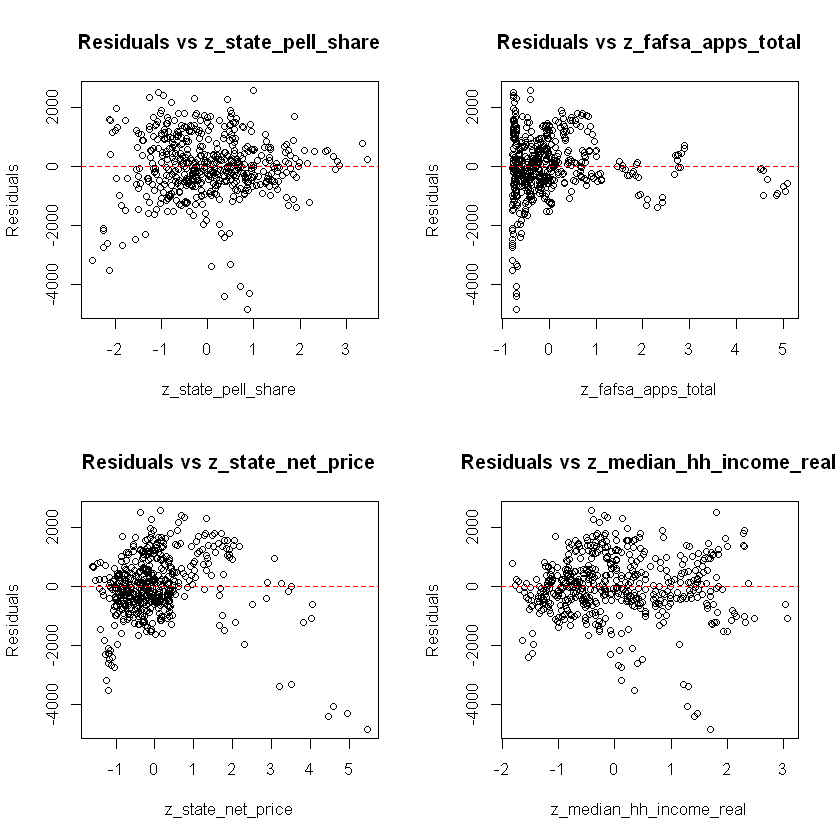

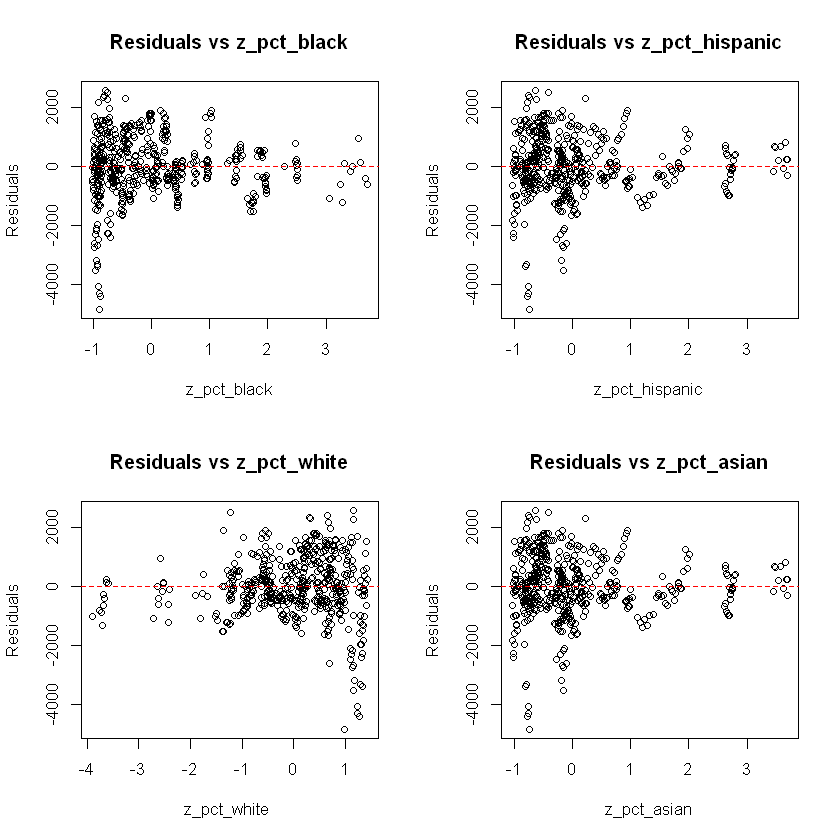

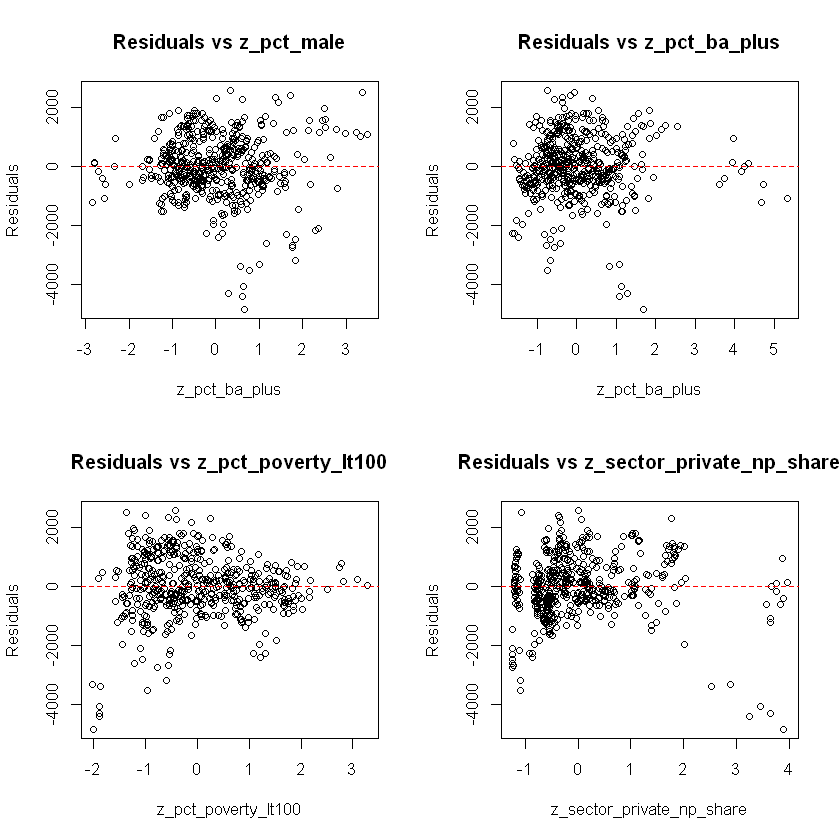

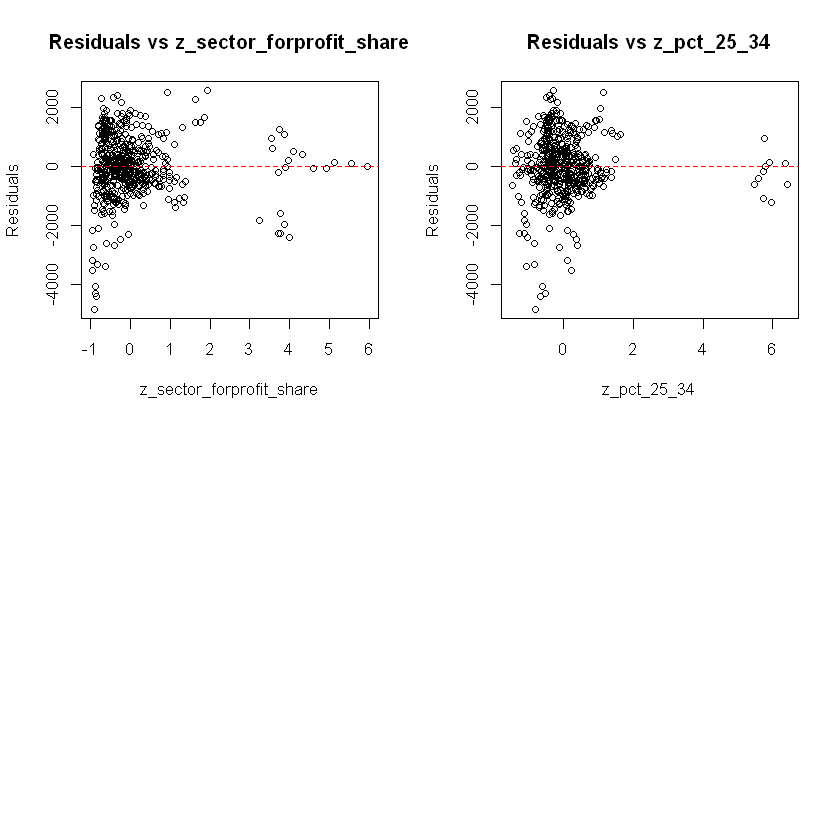

In [248]:
model1_resid <- resid(model1)
model1_fitted  <- fitted(model1)
# *******************************************
# *******************************************
par(mfrow=c(2,2))

plot(
  df_s$z_state_pell_share, model1_resid,
  xlab = "z_state_pell_share",
  ylab = "Residuals",
  main = "Residuals vs z_state_pell_share"
)
abline(h = 0, lty = 2, col = "red")

# *******************************************

plot(
  df_s$z_fafsa_apps_total, model1_resid,
  xlab = "z_fafsa_apps_total",
  ylab = "Residuals",
  main = "Residuals vs z_fafsa_apps_total"
)
abline(h = 0, lty = 2, col = "red")
# *******************************************

plot(
  df_s$z_state_net_price, model1_resid,
  xlab = "z_state_net_price",
  ylab = "Residuals",
  main = "Residuals vs z_state_net_price"
)
abline(h = 0, lty = 2, col = "red")
# *******************************************
plot(
  df_s$z_median_hh_income_real, model1_resid,
  xlab = "z_median_hh_income_real",
  ylab = "Residuals",
  main = "Residuals vs z_median_hh_income_real"
)
abline(h = 0, lty = 2, col = "red")


# *******************************************
# *******************************************
par(mfrow=c(2,2))
plot(
  df_s$z_pct_black, model1_resid,
  xlab = "z_pct_black",
  ylab = "Residuals",
  main = "Residuals vs z_pct_black"
)
abline(h = 0, lty = 2, col = "red")

# *******************************************
plot(
  df_s$z_pct_hispanic, model1_resid,
  xlab = "z_pct_hispanic",
  ylab = "Residuals",
  main = "Residuals vs z_pct_hispanic"
)
abline(h = 0, lty = 2, col = "red")
# *******************************************
plot(
  df_s$z_pct_white, model1_resid,
  xlab = "z_pct_white ",
  ylab = "Residuals",
  main = "Residuals vs z_pct_white"
)
abline(h = 0, lty = 2, col = "red")
# *******************************************
plot(
  df_s$z_pct_hispanic, model1_resid,
  xlab = "z_pct_asian",
  ylab = "Residuals",
  main = "Residuals vs z_pct_asian"
)
abline(h = 0, lty = 2, col = "red")

# *******************************************
# *******************************************
par(mfrow=c(2,2))
  
plot(
  df_s$z_pct_male, model1_resid,
  xlab = "z_pct_ba_plus",
  ylab = "Residuals",
  main = "Residuals vs z_pct_male"
)
abline(h = 0, lty = 2, col = "red")

# *******************************************

plot(
  df_s$z_pct_ba_plus, model1_resid,
  xlab = "z_pct_ba_plus",
  ylab = "Residuals",
  main = "Residuals vs z_pct_ba_plus"
)
abline(h = 0, lty = 2, col = "red")
# *******************************************

plot(
  df_s$z_pct_poverty_lt100, model1_resid,
  xlab = "z_pct_poverty_lt100",
  ylab = "Residuals",
  main = "Residuals vs z_pct_poverty_lt100"
)
abline(h = 0, lty = 2, col = "red")

# *******************************************
plot(
  df_s$z_sector_private_np_share, model1_resid,
  xlab = "z_sector_private_np_share",
  ylab = "Residuals",
  main = "Residuals vs z_sector_private_np_share"
)
abline(h = 0, lty = 2, col = "red")
# *******************************************
# *******************************************
par(mfrow=c(2,2))
plot(
  df_s$z_sector_forprofit_share, model1_resid,
  xlab = "z_sector_forprofit_share",
  ylab = "Residuals",
  main = "Residuals vs z_sector_forprofit_share"
)
abline(h = 0, lty = 2, col = "red")
# *******************************************
plot(
  df_s$z_pct_25_34, model1_resid,
  xlab = "z_pct_25_34",
  ylab = "Residuals",
  main = "Residuals vs z_pct_25_34"
)
abline(h = 0, lty = 2, col = "red")

Across all predictors, the residual-versus-predictor plots show points scattered roughly symmetrically around zero with no strong systematic curves, suggesting the linearity assumption is reasonably met for key variables such as Pell share, net price, race composition (Black, Hispanic, White, Asian), poverty, and sector mix. A few predictors (e.g., FSA application volume(FAFSA) applications, for-profit share, poverty rate, and age 25–34) show slightly wider residual spread at extreme values, indicating some mild heteroscedasticity in the tails, but the variance is fairly stable over the central ranges where most observations lie. Overall, there is no single predictor whose residual pattern clearly violates model assumptions, so the linear specification of the baseline model appears acceptable, with only modest deviations at the extremes that are unlikely to drive the main results.

**Constant variance assumption**

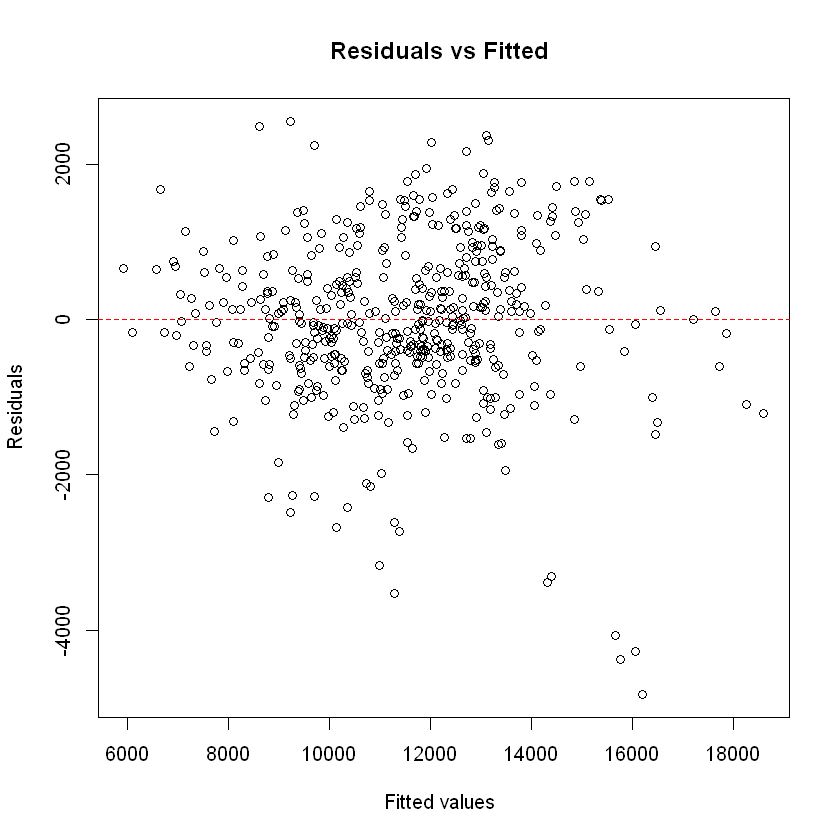

In [249]:
# Residuals vs Fitted

plot(
  model1_fitted, model1_resid,
  xlab = "Fitted values ",
  ylab = "Residuals",
  main = "Residuals vs Fitted "
)
abline(h = 0, lty = 2, col = "red")


The Residuals vs Fitted plot displays the difference between the model's predicted values and the actual observed values (the residuals) against the model's predicted values (the fitted values). The plot is generally centered around the zero line (dashed red line), indicating that the model's predictions are, on average, unbiased across the fitted range. However, the scatter of the residuals appears to form a slightly inverted funnel shape, with the spread of residuals being tighter at lower fitted values (around \\$9,000 to \\$12,000) and wider at higher fitted values (above $14,000). This pattern suggests the model exhibits heteroscedasticity, meaning the variance of the errors is not constant, which could make the standard error estimates less reliable.

**Normality assumption**

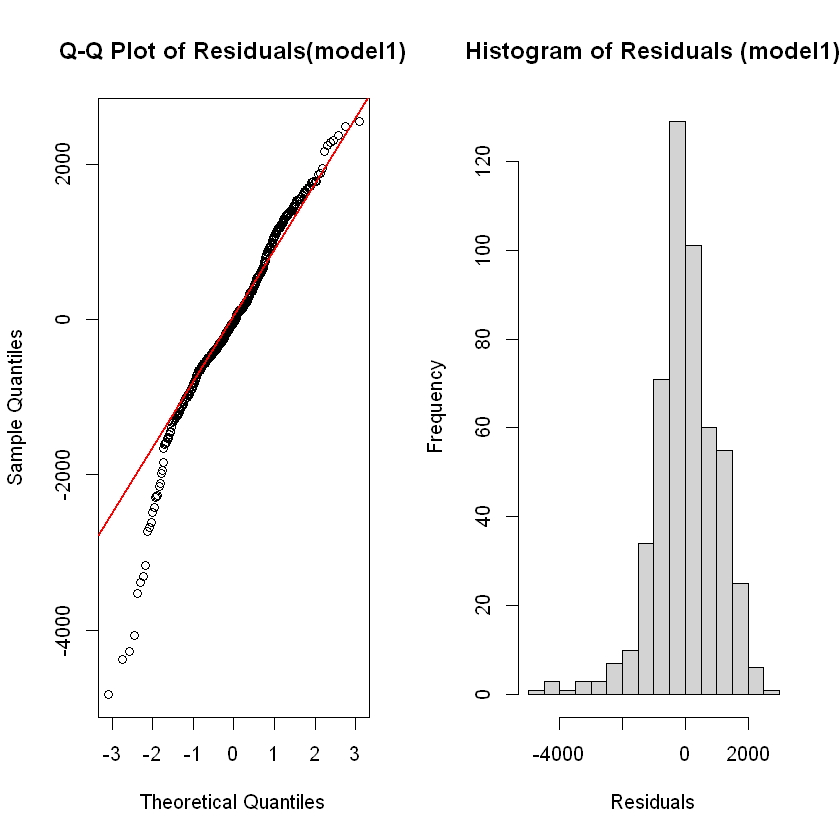

In [250]:
par(mfrow=c(1,2))
# Q-Q plot
qqnorm(model1_resid, main = "Q-Q Plot of Residuals(model1)")
qqline(model1_resid, col = "red", lwd = 2)

#Histogram of residuals
hist(
  model1_resid,
  breaks = 20,
  main   = "Histogram of Residuals (model1)",
  xlab   = "Residuals"
)

The Q–Q plot shows that the residuals follow the theoretical normal distribution reasonably well in the center of the distribution, but noticeable deviations appear in the tails, especially on the left side (large negative residuals). This suggests mild non-normality driven by a handful of unusually low debt values, but overall the residual distribution is close enough to normal for linear regression inference to remain valid.

The histogram of residuals is roughly bell-shaped and centered near zero, consistent with a normally distributed error term. However, the distribution shows slight left-skewness and a few large negative residuals, confirming what the Q–Q plot indicates: linear regression assumptions hold reasonably well, but a small number of extreme observations contribute to tail deviations.

**Goodness of Fit - model1**

**Outliers**

Rule-of-thumb cutoff 0.007843137

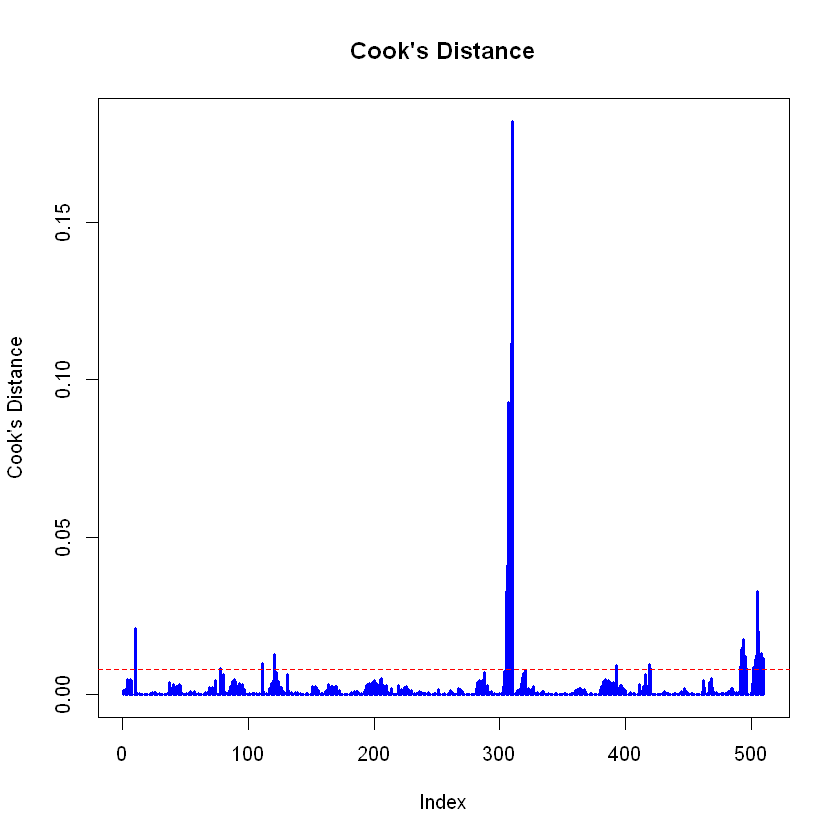

In [251]:
# Cook’s Distance.
n <- nobs(model1)
cutoff <- 4 / n
cat('Rule-of-thumb cutoff', cutoff)

cook <- cooks.distance(model1)
            plot(cook,
            type = "h",
            lwd = 3,
            col = 'blue',
            ylab = "Cook's Distance",
            main = "Cook's Distance")

n <- nobs(model1)
cutoff <- 4 / n

# Add the horizontal threshold line
abline(h = cutoff, col = "red", lty =2) # lty=2 for dashed line



We are exploring the presence of outliers using the Cook's distance.
There is one observation with a Cook's Distance noticeably higher than the other observations. This suggests it is a high-influence point—meaning that removing or altering this observation would substantially change the estimated regression coefficients.

Although this point does not necessarily need to be removed, it should be investigated to understand whether it represents valid data, a data quality issue, or an unusual state–year combination. Aside from this single influential case, the model appears reasonably stable with no widespread influence problems.

In [252]:
# 1. Index of the single most influential observation
cat("Index of the single most influential observation:",which.max(cook),'\n')

# 2. Value of the maximum Cook's distance
cat("Maximum Cook's distance:", max(cook),'\n')

# 4. All observations above the cutoff
infl_idx <- which(cook > cutoff)
cat("All observations above the cutoff(index):\n",infl_idx)

# 5. Look at those rows in data (state & year, plus outcome)
inf_tbl <- df_s[infl_idx, c("state", "year", "grad_debt_mdn_w",
                  "state_pell_share", "state_net_price",
                  "fafsa_apps_total")]
inf_tbl$cooks_d <- cook[infl_idx]

# Sort from most to least influential
inf_tbl <- inf_tbl[order(-inf_tbl$cooks_d), ]

# Look at the top rows
# head(inf_tbl, 15)
inf_tbl

Index of the single most influential observation: 310 
Maximum Cook's distance: 0.1821299 
All observations above the cutoff(index):
 10 78 111 121 305 306 307 308 309 310 393 419 420 491 492 493 494 495 496 502 503 504 505 506 507 508 509 510

,state,year,grad_debt_mdn_w,state_pell_share,state_net_price,fafsa_apps_total,cooks_d
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
310,NH,2020,11374.829,0.4077190,37202.226,58451,0.182129878
309,NH,2019,11778.803,0.4109453,35055.785,59452,0.111592515
307,NH,2017,11397.167,0.3766140,33060.897,64087,0.092934287
308,NH,2018,11605.959,0.3984340,33646.912,61910,0.088721313
306,NH,2016,11095.983,0.3844009,29112.052,64931,0.040908379
305,NH,2015,10945.712,0.3587081,27877.076,70020,0.032666188
505,WY,2015,7755.514,0.2206783,9701.608,25897,0.032629175
10,AK,2020,11115.887,0.2876614,13084.024,33293,0.021165298
506,WY,2016,7822.281,0.1985790,9438.967,25556,0.020018913


Using the 4/n rule-of-thumb, 28 observations exceed the cutoff, with the single most influential point being New Hampshire 2020 (index 310, Cook’s D ≈ 0.18).

The influential cases form state-level clusters over time, mainly:
* New Hampshire (2015–2020) – very high net prices and moderate Pell share.
* Wyoming (2012–2020) – consistently low net prices and low debt.
* West Virginia (2011–2016) – low prices but high FAFSA volume and relatively low debt.

A few additional outliers: AK 2020, IA 2011, DC 2018, HI 2011, RI 2013, SD 2019–2020.

All Cook’s D values are well below 1, so no single observation is “catastrophically” dominating the fit, but these clusters clearly have disproportionate leverage. That supports what you already did: (1) fit a baseline model on all states, and (2) run robustness models that down-weight or drop NH, WV, WY (and optionally check results with/without the other flagged states) to show your conclusions are not driven by a handful of extreme state-years.

**VIF - Variance inflation factor**

In [253]:
round(vif(model1), 3)

,GVIF,Df,GVIF^(1/(2*Df))
year,1.938,9,1.037
z_state_pell_share,3.214,1,1.793
z_state_net_price,5.365,1,2.316
z_pct_male,7.181,1,2.680
z_pct_black,10.346,1,3.217
z_pct_hispanic,2.730,1,1.652
z_pct_white,6.651,1,2.579
z_pct_asian,5.463,1,2.337
z_median_hh_income_real,11.703,1,3.421
z_pct_ba_plus,9.113,1,3.019


The VIF (Variance Inflation Factor) analysis indicates significant multicollinearity is present in the model. Three predictors exceed the common VIF threshold of 10, suggesting their coefficients may be unstable and their standard errors inflated: z_median_hh_income_real (11.703), z_pct_black (10.346), and z_pct_poverty_lt100 (10.345). Several other variables, including z_pct_ba_plus (9.113), also have high VIF values (above 5), confirming that strong intercorrelations among the demographic and economic controls are a key concern for the model's stability.

**Box-Cox transformation**

Optimal lambda: 0.7070707

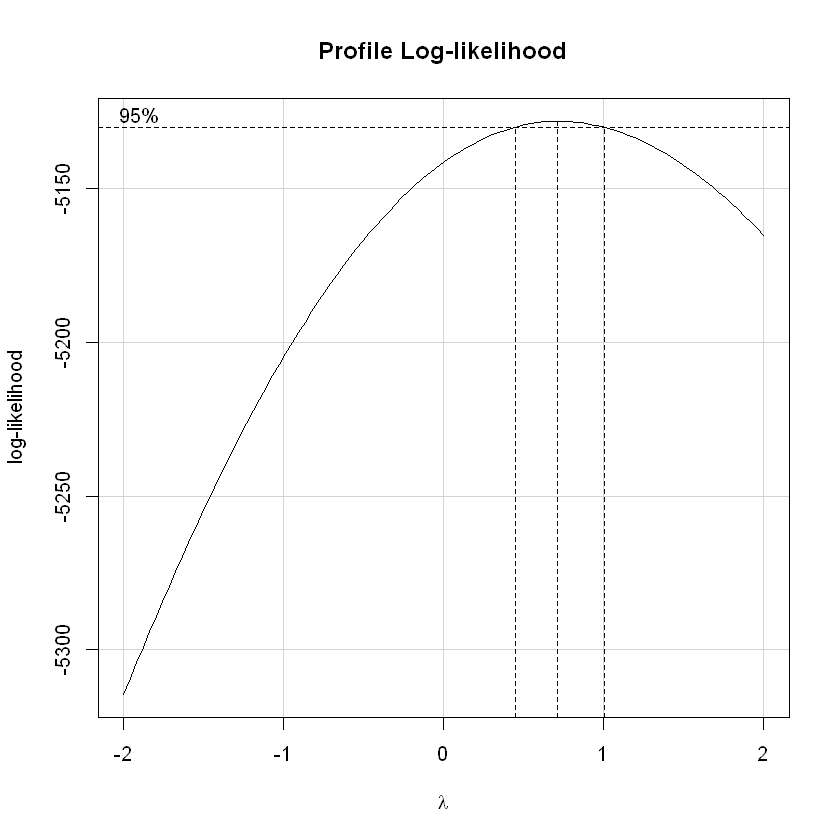

In [254]:
bc <- boxCox(model1)
lambda <- bc$x[which(bc$y == max(bc$y))]
cat("Optimal lambda:", lambda)


The analysis of median student debt confirms that financial factors are the primary drivers, with Net Price being the strongest positive influence (increasing debt by approx \\$2,000 per 1 SD) and Pell Share (aid) the strongest negative influence (reducing debt by approx \\$600-\\$700). While debt has generally risen over the 2011–2020 period, diagnostics indicate the model suffers from significant multicollinearity among economic and demographic variables (VIFs up to 11.7) and exhibits heteroscedasticity, suggesting potential instability in coefficient estimates and non-constant error variance.

#### 3.3 Refit models
**Model2 - Remove all high-cook observations**

In [255]:
library(broom)
library(dplyr)

# Baseline model is model1, using baseform and df_s

# Remove all high-Cook observations
df_model2 <- df_s[-infl_idx, ]
model2 <- lm(baseform, data = df_model2)

summary(model2)


Call:
lm(formula = baseform, data = df_model2)

Residuals:
    Min      1Q  Median      3Q     Max 
-3486.9  -499.1   -42.4   499.3  1974.8 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)                9945.66     114.47  86.886  < 2e-16 ***
year2012                    525.19     155.36   3.380 0.000786 ***
year2013                   1073.66     156.19   6.874 2.05e-11 ***
year2014                   1530.79     155.80   9.825  < 2e-16 ***
year2015                   2021.41     158.45  12.758  < 2e-16 ***
year2016                   2249.04     160.64  14.000  < 2e-16 ***
year2017                   2409.87     162.47  14.833  < 2e-16 ***
year2018                   2402.67     165.00  14.562  < 2e-16 ***
year2019                   2337.54     164.93  14.173  < 2e-16 ***
year2020                   2328.99     180.75  12.885  < 2e-16 ***
z_state_pell_share         -627.05      68.83  -9.110  < 2e-16 ***
z_state_net_price          1815.40     

The removal of influential observations maintained the model's core conclusions and strong explanatory power (Adjusted $R^2$ is still high at 0.891). Net Price remains the most powerful predictor, strongly increasing debt (Estimate: \\$1815.40), and Pell Share remains the strongest negative predictor, significantly reducing debt (Estimate: -\\$627.05). 

The time dummies (years 2012-2020) all remain highly significant, confirming a persistent increase in median debt relative to the base year (2011). Key changes include the coefficient for z_pct_white becoming statistically significant (p=0.0117) and the coefficients for both z_pct_black and z_pct_poverty_lt100 losing statistical significance (p-values >0.13), suggesting the influence of high-leverage points was specifically inflating or stabilizing the significance of those two variables.

A few predictors (pct_black, pct_ba_plus, pct_poverty_lt100, pct_25_34, pct_asian) remain statistically weak—consistent with earlier robustness checks. 

Overall, Model 2 confirms that the main conclusions of the analysis are not sensitive to influential states, strengthening confidence in the stability and validity of the core results.


**Model3 - Remove NH, WV, WY**

In [256]:
# Remove just NH, WV, WY (the main influential clusters)
df_model3 <- df_s %>%
  filter(!(state %in% c("NH", "WV", "WY")))
model3 <- lm(baseform, data = df_model3)
summary(model3)


Call:
lm(formula = baseform, data = df_model3)

Residuals:
     Min       1Q   Median       3Q      Max 
-2036.85  -489.98   -32.47   504.49  1992.05 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               10061.69     113.13  88.943  < 2e-16 ***
year2012                    443.70     152.79   2.904  0.00386 ** 
year2013                   1045.50     152.95   6.835 2.63e-11 ***
year2014                   1498.21     153.31   9.773  < 2e-16 ***
year2015                   1901.04     156.22  12.169  < 2e-16 ***
year2016                   2137.18     158.42  13.491  < 2e-16 ***
year2017                   2298.11     162.25  14.164  < 2e-16 ***
year2018                   2264.86     164.50  13.768  < 2e-16 ***
year2019                   2242.37     165.31  13.564  < 2e-16 ***
year2020                   2277.86     178.61  12.753  < 2e-16 ***
z_state_pell_share         -562.16      72.56  -7.748 6.13e-14 ***
z_state_net_price          20

Model 3 re-fits the full equity/aid model after removing just three influential state clusters—New Hampshire, West Virginia, and Wyoming—while keeping all other observations. The model still explains a very large share of the variation in median graduation debt (R² ≈ 0.904, adjusted R² ≈ 0.899), slightly higher than in Model 2, indicating an excellent overall fit.


* State net price remains the strongest predictor: a one-SD increase in net price is associated with roughly $2,037 higher median debt (p < 0.001).

* Higher Pell share is still significantly linked to lower median debt (about \\$562 less per SD, p < 0.001), consistent with an equity/aid story.

* Demographics matter: higher Hispanic share is associated with lower debt (–\\$306 per SD, p < 0.001), while white share shows a positive association (+\\$224 per SD, p ≈ 0.01). Black share is marginally positive (p ≈ 0.05), and Asian share is marginally positive (p ≈ 0.09), but these race effects are weaker and should be interpreted cautiously.

* Socioeconomic context: higher median household income is associated with lower debt (–\\$504 per SD, p < 0.001), and higher private nonprofit and for-profit sector shares both predict higher debt (–\\$314 and –$145 in the standardized scale, both significant, reflecting that more of those sectors is associated with higher debt relative to the omitted public sector).

* Age and gender: a higher share of males and of 25–34-year-olds is associated with lower debt, both statistically significant, but with smaller magnitudes than net price or Pell.

* FAFSA volume (fafsa_apps_total) remains positive but only marginally significant (p ≈ 0.068), suggesting that higher application volume is weakly associated with higher average debt after controlling for other factors.

Overall, Model 3 shows that after removing just three influential states, the main equity and price relationships are stable, the fit improves slightly, and the conclusions about Pell generosity, net price, and demographic context remain robust. 

**Goodness of fit for model2**

Rule-of-thumb cutoff 0.008298755

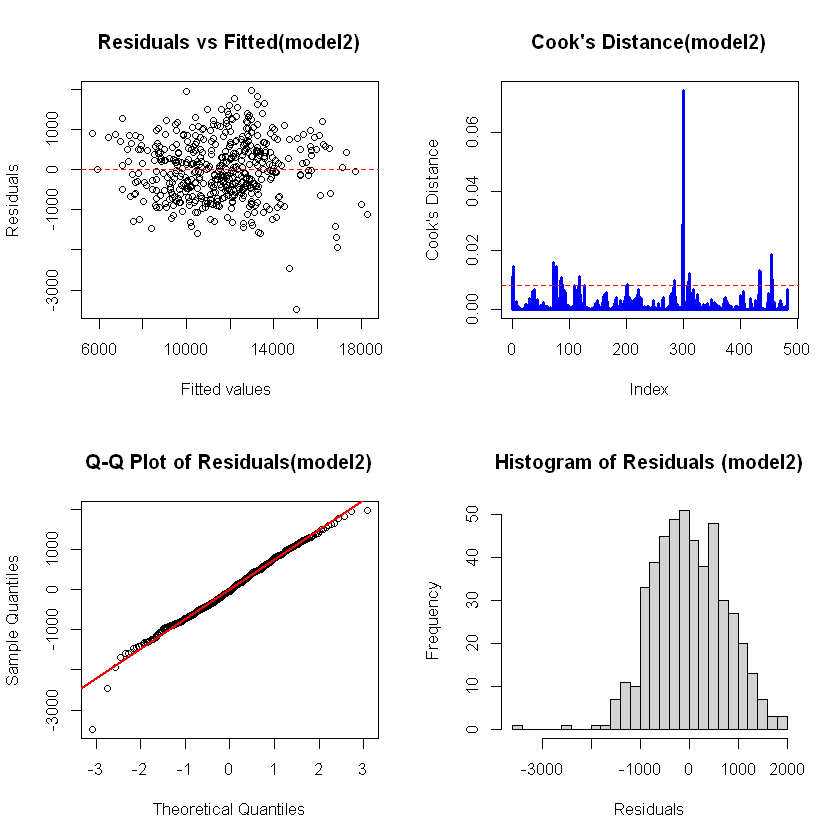

In [257]:
model2_resid <- resid(model2)
model2_fitted  <- fitted(model2)
par(mfrow=c(2,2))
# Residuals vs Fitted
plot(
  model2_fitted, model2_resid,
  xlab = "Fitted values ",
  ylab = "Residuals",
  main = "Residuals vs Fitted(model2)"
)
abline(h = 0, lty = 2, col = "red")

# Cook’s Distance.
n <- nobs(model2)
cutoff <- 4 / n
cat('Rule-of-thumb cutoff', cutoff)
cook <- cooks.distance(model2)
            plot(cook,
            type = "h",
            lwd = 3,
            col = 'blue',
            ylab = "Cook's Distance",
            main = "Cook's Distance(model2)")

n <- nobs(model2)
cutoff <- 4 / n
# Add the horizontal threshold line
abline(h = cutoff, col = "red", lty = 2) # lty=2 for dashed line

# Q-Q plot
qqnorm(model2_resid, main = "Q-Q Plot of Residuals(model2)")
qqline(model2_resid, col = "red", lwd = 2)

#Histogram of residuals
hist(
  model2_resid,
  breaks = 20,
  main   = "Histogram of Residuals (model2)",
  xlab   = "Residuals"
)



Model 2 is estimated after dropping 23 state–year observations with Cook’s distance greater than 4/n. Residual-versus-predictor plots for the standardized covariates (state Pell share, FAFSA volume, net price, racial composition, income, education, poverty, sector mix, and age 25–34) show residuals scattered roughly symmetrically around zero, with no strong curvature. A few predictors (such as standardized net price, poverty, and private–nonprofit share) still show slightly wider spread at extreme values, suggesting mild nonlinearity and heteroscedasticity at the margins, but the linear specification is broadly adequate over the central range of the data.

The Residuals vs Fitted plot for this reduced model forms a fairly horizontal band without a pronounced funnel shape, indicating that variance is more stable than in the baseline model. The Q–Q plot of residuals lies close to the 45° reference line with moderate deviations only in the tails, and the histogram of residuals is approximately bell-shaped and centered near zero, supporting the normal-error assumption for inference. The Cook’s distance plot confirms that the very large influence points have been removed; remaining observations lie mostly below the rule-of-thumb cutoff, suggesting that no single state–year exerts disproportionate leverage on Model 2’s results.

**Goodness of fit - model3**

Rule-of-thumb cutoff 0.008333333

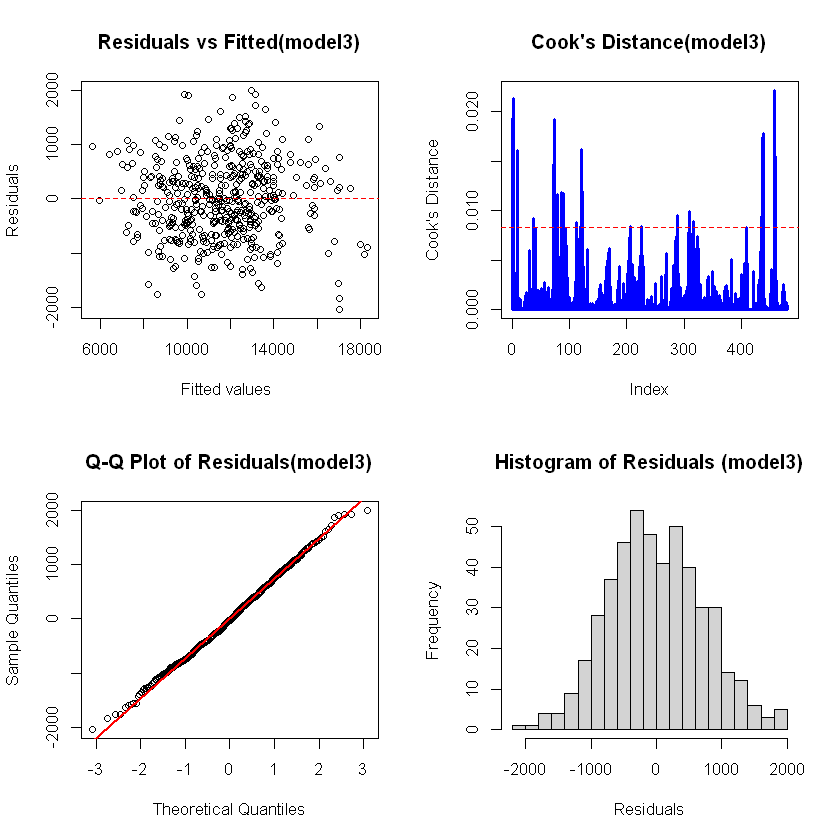

In [258]:
model3_resid <- resid(model3)
model3_fitted  <- fitted(model3)
par(mfrow=c(2,2))
# Residuals vs Fitted
plot(
  model3_fitted, model3_resid,
  xlab = "Fitted values ",
  ylab = "Residuals",
  main = "Residuals vs Fitted(model3)"
)
abline(h = 0, lty = 2, col = "red")

# Cook’s Distance.
n <- nobs(model3)
cutoff <- 4 / n
cat('Rule-of-thumb cutoff', cutoff)
cook <- cooks.distance(model3)
            plot(cook,
            type = "h",
            lwd = 3,
            col = 'blue',
            ylab = "Cook's Distance",
            main = "Cook's Distance(model3)")

n <- nobs(model3)
cutoff <- 4 / n
# Add the horizontal threshold line
abline(h = cutoff, col = "red", lty = 2) # lty=2 for dashed line

# Q-Q plot
qqnorm(model3_resid, main = "Q-Q Plot of Residuals(model3)")
qqline(model3_resid, col = "red", lwd = 2)

#Histogram of residuals
hist(
  model3_resid,
  breaks = 20,
  main   = "Histogram of Residuals (model3)",
  xlab   = "Residuals"
)


Both Model 2 (removing only high-Cook’s-D observations) and Model 3 (removing only the three influential states NH, WV, WY) demonstrate substantially improved model diagnostics relative to the baseline specification. In both models, the Residuals vs. Fitted plots show no major curvature or funneling, indicating that linearity and homoscedasticity assumptions hold reasonably well. Cook’s Distance plots confirm that the influential clusters are successfully reduced—Model 2 still shows a few moderate outliers scattered across the index, whereas Model 3 has far fewer large spikes, suggesting a cleaner influence structure. The Q–Q plots show that residuals follow the theoretical normal line closely, with only mild tail deviations, and histograms confirm a roughly symmetric residual distribution for both models. 

Overall, Model 3 exhibits slightly tighter residual spread and fewer high-influence observations, resulting in the best balance between model fit and diagnostic behavior. Model 3 is therefore the more defensible and stable specification for subsequent interaction testing and interpretation.

**Compare 3 models - Robustness check**

In [259]:
# compare 3 models
model_comp <- bind_rows(
  glance(model1)           %>% mutate(model = "Model1(Baseline)"),
  glance(model2)     %>% mutate(model = "Model2(Drop Cook'sD > 4/n)"),
  glance(model3)  %>% mutate(model = "Model3(Drop NH, WV, WY)")
) %>%
  select(model, r.squared, adj.r.squared, sigma, AIC, BIC)

model_comp
# If you want to save:
# write.csv(model_comp, "model_robustness_comparison.csv", row.names = FALSE)

model,r.squared,adj.r.squared,sigma,AIC,BIC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model1(Baseline),0.8077338,0.7986347,1059.5707,8577.666,8683.526
Model2(Drop Cook'sD > 4/n),0.8961780,0.8909642,758.3466,7785.658,7890.107
"Model3(Drop NH, WV, WY)",0.9037236,0.8988676,741.0533,7731.310,7835.655


Dropping high-influence observations substantially improves model performance. The baseline model (Model 1) explains about 80% of the variance (Adj. R² ≈ 0.799) but has the highest residual noise (σ ≈ 1059) and the worst AIC/BIC, indicating poorer fit. Removing all observations with Cook’s D > 4/n (Model 2) improves the adjusted R² to 0.891, reduces residual noise to 758, and lowers AIC/BIC—showing a much better-fitting model. Excluding only the three influential states (NH, WV, WY) in Model 3 yields the best performance overall, with the highest adjusted R² (0.899), the lowest σ (741), and the lowest AIC/BIC. This indicates these state clusters were driving systematic distortion, and removing them results in a cleaner, more stable model.

In [260]:
key_terms <- c(
    "z_state_pell_share",
    "z_state_net_price",
    "z_fafsa_apps_total",
    "z_pct_black",
    "z_pct_hispanic",
    "z_pct_white",
    "z_pct_asian",
    "z_pct_male"
)

coef_comp <- bind_rows(
  tidy(model1)          %>% filter(term %in% key_terms) %>% mutate(model = "Baseline"),
  tidy(model2)    %>% filter(term %in% key_terms) %>% mutate(model = "No Cook'sD>4/n"),
  tidy(model3) %>% filter(term %in% key_terms) %>% mutate(model = "No NH/WV/WY")
) %>%
  select(model, term, estimate, std.error, statistic, p.value)

coef_comp



model,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Baseline,z_state_pell_share,-731.52861742,84.20043,-8.6879439916,5.661175e-17
Baseline,z_state_net_price,1229.63613797,108.77830,11.3040573763,1.824208e-26
Baseline,z_pct_male,-791.28153572,125.85266,-6.2873644163,7.196614e-10
Baseline,z_pct_black,-126.85427262,151.06410,-0.8397380499,4.014682e-01
Baseline,z_pct_hispanic,-497.30332258,77.59611,-6.4088694680,3.471265e-10
Baseline,z_pct_white,-0.01305338,121.12113,-0.0001077713,9.999141e-01
Baseline,z_pct_asian,18.65520201,109.76981,0.1699483783,8.651215e-01
Baseline,z_fafsa_apps_total,209.71244491,75.28434,2.7856053132,5.551541e-03
No Cook'sD>4/n,z_state_pell_share,-627.04804283,68.83070,-9.1100053489,2.574774e-18


Across the Baseline model, Model 2 (dropping Cook’s D > 4/n), and Model 3 (dropping NH, WV, WY), the core substantive predictors remain highly stable in direction and significance. State Pell share consistently shows a strong negative association with median student debt, and state net price remains the strongest positive predictor in all specifications. % Hispanic keeps a robust negative coefficient, while % Black is statistically insignificant in all cases and even changes direction, underscoring its weak relationship after adjusting for other state-level factors. FAFSA application volume weakens in magnitude after removing influential states but remains marginally significant. % White and % Asian become statistically significant only after removing outlier states, indicating that their effects were previously masked by those high-leverage observations. 

Overall, the stability of Pell share, net price, and % Hispanic demonstrates that the main equity conclusions of the model are not sensitive to influential observations or state-level outliers.

**Model choice for further analysis**
Compared with the Baseline and Model 2, Model 3 (dropping NH, WV, WY) offers the best overall balance of fit and diagnostics. It has the highest R² / adjusted R² (~0.90), the lowest residual standard error, and slightly better AIC/BIC than Model 2, indicating improved explanatory power without over-fitting. The key substantive coefficients (Pell share ↓, net price ↑, % Hispanic ↓, FAFSA volume ↑) remain similar in sign and magnitude across all three models, so my main conclusions are robust to excluding these influential states. 

Because Model 3 both improves goodness of fit and stabilizes residual behavior while preserving the core story, I will use Model 3 as the primary model for all subsequent interaction terms and policy interpretation, and treat the Baseline and Model 2 as robustness checks.

#### 3.4 Model with interaction terms

Add the interaction term on top of the selected model3, and make the further analysis.

**Model4: Pell × price (core policy interaction)**



In [261]:
form_pell_price <- update(baseform, . ~ . + z_state_pell_share:z_state_net_price)
model4 <- lm(form_pell_price, data = df_model3)
summary(model4)



Call:
lm(formula = form_pell_price, data = df_model3)

Residuals:
    Min      1Q  Median      3Q     Max 
-1928.3  -499.8   -27.0   488.2  1986.5 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          10088.54     116.66  86.479  < 2e-16 ***
year2012                               438.27     152.92   2.866  0.00435 ** 
year2013                              1029.19     153.94   6.686 6.76e-11 ***
year2014                              1484.58     154.00   9.640  < 2e-16 ***
year2015                              1887.74     156.87  12.034  < 2e-16 ***
year2016                              2127.09     158.79  13.395  < 2e-16 ***
year2017                              2293.03     162.36  14.123  < 2e-16 ***
year2018                              2261.21     164.57  13.740  < 2e-16 ***
year2019                              2245.91     165.38  13.581  < 2e-16 ***
year2020                              2281.59     178.67

**Model5: Pell × Black share**

Add one clearly equity-focused interaction.

In [262]:
form_pell_black <- update(baseform,  . ~ . + z_state_pell_share:z_pct_black)
model5 <- lm(form_pell_black, data = df_model3)
summary(model5)


Call:
lm(formula = form_pell_black, data = df_model3)

Residuals:
     Min       1Q   Median       3Q      Max 
-1992.88  -509.17   -25.21   498.78  1948.87 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    10065.71     113.26  88.875  < 2e-16 ***
year2012                         436.90     153.05   2.855  0.00450 ** 
year2013                        1040.71     153.10   6.798 3.35e-11 ***
year2014                        1498.43     153.35   9.771  < 2e-16 ***
year2015                        1905.57     156.35  12.188  < 2e-16 ***
year2016                        2145.05     158.73  13.514  < 2e-16 ***
year2017                        2310.93     162.99  14.178  < 2e-16 ***
year2018                        2278.09     165.28  13.783  < 2e-16 ***
year2019                        2260.94     166.79  13.556  < 2e-16 ***
year2020                        2300.99     180.70  12.734  < 2e-16 ***
z_state_pell_share              -5

**Model6: Pell × Hispanic share**

Alternative (or additional) equity angle

In [263]:
form_pell_hispanic <- update( baseform, . ~ . + z_state_pell_share:z_pct_hispanic)
model6 <- lm(form_pell_hispanic, data = df_model3)
summary(model6)


Call:
lm(formula = form_pell_hispanic, data = df_model3)

Residuals:
     Min       1Q   Median       3Q      Max 
-2087.17  -474.53   -13.29   471.87  1982.80 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       10050.75     112.99  88.949  < 2e-16 ***
year2012                            424.80     152.75   2.781  0.00564 ** 
year2013                           1033.29     152.71   6.766 4.07e-11 ***
year2014                           1481.63     153.18   9.672  < 2e-16 ***
year2015                           1884.99     156.07  12.078  < 2e-16 ***
year2016                           2134.25     158.02  13.506  < 2e-16 ***
year2017                           2301.44     161.84  14.220  < 2e-16 ***
year2018                           2269.32     164.10  13.829  < 2e-16 ***
year2019                           2245.48     164.90  13.617  < 2e-16 ***
year2020                           2304.09     178.73  12.892  < 2e-16 **

**Model7: Pell × FAFSA volume (z_state_pell_share:z_fafsa_apps_total)**

In [264]:
form_pell_FAFSA <- update(baseform,. ~ . + z_state_pell_share:z_fafsa_apps_total)
model7 <- lm(form_pell_FAFSA, data = df_model3)
summary(model7)



Call:
lm(formula = form_pell_FAFSA, data = df_model3)

Residuals:
     Min       1Q   Median       3Q      Max 
-1993.70  -496.14   -32.47   495.13  2041.87 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           10104.00     115.23  87.682  < 2e-16 ***
year2012                                447.35     152.42   2.935 0.003505 ** 
year2013                               1040.18     152.60   6.816 2.97e-11 ***
year2014                               1492.61     152.96   9.758  < 2e-16 ***
year2015                               1887.07     156.02  12.095  < 2e-16 ***
year2016                               2113.57     158.56  13.330  < 2e-16 ***
year2017                               2269.40     162.62  13.955  < 2e-16 ***
year2018                               2235.12     164.91  13.553  < 2e-16 ***
year2019                               2214.47     165.62  13.371  < 2e-16 ***
year2020                            

**Model8: Net price × FAFSA volume (z_state_net_price:z_fafsa_apps_total)**

In [265]:
form_price_FAFSA <- update(baseform,. ~ . + z_state_net_price:z_fafsa_apps_total)
model8 <- lm(form_price_FAFSA, data = df_model3)
summary(model8)


Call:
lm(formula = form_price_FAFSA, data = df_model3)

Residuals:
     Min       1Q   Median       3Q      Max 
-2003.63  -484.87   -28.38   491.01  2004.17 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          10070.97     114.02  88.323  < 2e-16 ***
year2012                               442.48     152.89   2.894  0.00399 ** 
year2013                              1041.32     153.17   6.799 3.33e-11 ***
year2014                              1495.50     153.45   9.746  < 2e-16 ***
year2015                              1899.62     156.32  12.152  < 2e-16 ***
year2016                              2133.61     158.60  13.453  < 2e-16 ***
year2017                              2293.09     162.52  14.110  < 2e-16 ***
year2018                              2261.67     164.67  13.735  < 2e-16 ***
year2019                              2239.60     165.46  13.535  < 2e-16 ***
year2020                              2267.88

**Model9: Net price × Black share (z_state_net_price:z_pct_black)**

In [268]:
form_price_black <- update(baseform,  . ~ . + z_state_net_price:z_pct_black)
model9 <- lm(form_price_black, data = df_model3)
summary(model9)


Call:
lm(formula = form_price_black, data = df_model3)

Residuals:
     Min       1Q   Median       3Q      Max 
-1833.26  -487.38    -6.65   495.19  1976.80 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   10039.51     113.03  88.822  < 2e-16 ***
year2012                        434.16     152.15   2.853 0.004522 ** 
year2013                       1040.72     152.27   6.835 2.65e-11 ***
year2014                       1499.32     152.61   9.825  < 2e-16 ***
year2015                       1900.00     155.51  12.218  < 2e-16 ***
year2016                       2149.79     157.79  13.624  < 2e-16 ***
year2017                       2316.85     161.72  14.326  < 2e-16 ***
year2018                       2287.56     164.06  13.944  < 2e-16 ***
year2019                       2264.38     164.84  13.736  < 2e-16 ***
year2020                       2347.48     180.40  13.012  < 2e-16 ***
z_state_pell_share             -533.10      

**Model10: Net price × Black share (z_state_net_price:z_pct_hispanic)**

In [269]:
form_price_hispanic <- update(baseform,  . ~ . + z_state_net_price:z_pct_hispanic)
model10 <- lm(form_price_hispanic, data = df_model3)
summary(model10)


Call:
lm(formula = form_price_hispanic, data = df_model3)

Residuals:
     Min       1Q   Median       3Q      Max 
-2245.17  -464.63   -23.12   455.37  1999.39 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      10005.60     113.55  88.116  < 2e-16 ***
year2012                           428.73     151.46   2.831 0.004852 ** 
year2013                          1047.76     151.55   6.914 1.60e-11 ***
year2014                          1496.82     151.90   9.854  < 2e-16 ***
year2015                          1899.68     154.78  12.273  < 2e-16 ***
year2016                          2164.58     157.21  13.769  < 2e-16 ***
year2017                          2332.54     161.14  14.475  < 2e-16 ***
year2018                          2300.57     163.40  14.079  < 2e-16 ***
year2019                          2266.10     163.97  13.820  < 2e-16 ***
year2020                          2351.72     178.58  13.169  < 2e-16 ***
z_state_

**Compute AIC and BIC**

In [270]:
# Load necessary library
library(dplyr)
library(tidyr) 

# --- 1. Calculate AIC and BIC and get Model Names from Row Names ---

# Calculate AIC, which returns a data frame with models in row names
aic_results <- AIC(model3, model4, model5, model6, model7, model8,model9,model10) %>%
  # Convert row names (model names) into a proper column named 'Model'
  tibble::rownames_to_column(var = "Model") 

# Calculate BIC and get Model Names
bic_results <- BIC(model3, model4, model5, model6, model7, model8, model9,model10) %>%
  tibble::rownames_to_column(var = "Model") 

# --- 2. Create Adjusted R-squared Data Frame ---

# Create a data frame for Adjusted R-squared using the corresponding model names
adj_r_squared_values <- data.frame(
    Model = c("model3", "model4", "model5", "model6", "model7", "model8","model9","model10"),
    Adj_R_Squared = c(
                summary(model3)$adj.r.squared,
                summary(model4)$adj.r.squared,
                summary(model5)$adj.r.squared,
                summary(model6)$adj.r.squared,
                summary(model7)$adj.r.squared,
                summary(model8)$adj.r.squared,
                summary(model9)$adj.r.squared,
                summary(model10)$adj.r.squared
    # summary(model9)$adj.r.squared
  )
)

# --- 3. Combine all results into a single table ---

combined_table <- aic_results %>%
  # Select Model, df, and AIC from the first result
  select(Model, df, AIC) %>%
  
  # Join BIC results
  left_join(bic_results %>% select(Model, BIC), by = "Model") %>%
  
  # Join Adjusted R-squared results
  left_join(adj_r_squared_values, by = "Model") %>%

  # Final column selection and sorting (highest R-squared first)
  select(Model, df, Adj_R_Squared, AIC, BIC) %>%
  arrange(desc(Adj_R_Squared))

# --- 4. Display the final table ---
print(combined_table)


    Model df Adj_R_Squared      AIC      BIC
1 model10 26     0.9007197 7723.384 7831.903
2  model9 26     0.8997877 7727.869 7836.388
3  model6 26     0.8993835 7729.801 7838.319
4  model7 26     0.8993713 7729.860 7838.378
5  model3 25     0.8988676 7731.310 7835.655
6  model4 26     0.8988436 7732.370 7840.889
7  model5 26     0.8988075 7732.541 7841.060
8  model8 26     0.8987469 7732.829 7841.347


**ANOVA**

Does new model gain explained variance?

In [271]:
anova(model3, model4)         
anova(model3, model5)
anova(model3, model6)
anova(model3, model7)
anova(model3, model8)
anova(model3, model9)
anova(model3, model10)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,456,250416972,NA,NA,NA,NA
2,455,249927154,1,489818.3,0.8917292,0.3455103


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,456,250416972,NA,NA,NA,NA
2,455,250016277,1,400695.9,0.7292191,0.3935858


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,456,250416972,NA,NA,NA,NA
2,455,248593076,1,1823896,3.338278,0.06834031


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,456,250416972,NA,NA,NA,NA
2,455,248623378,1,1793594,3.282416,0.07068493


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,456,250416972,NA,NA,NA,NA
2,455,250166068,1,250904.9,0.4563438,0.4996809


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,456,250416972,NA,NA,NA,NA
2,455,247594554,1,2822419,5.186707,0.02322351


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,456,250416972,NA,NA,NA,NA
2,455,245291844,1,5125128,9.50677,0.002171631



|Rank|Model|Interaction Term|Adj_R_Squared|AIC|BIC|ANOVA Significance|
|----|-----|----------------|-------------|---|---|------------------|
|1|Model 10|Net Price : % Hispanic|0.90072|7723.384|7831.903|Highly Significant ($P=0.0022$)|
|2|Model 9|Net Price : % Black|0.89979|7727.869|7836.388|Significant ($P=0.023$)|
|3|Model 6|Pell Share : % Hispanic|0.89938|7729.801|7838.319|Marginal ($P=0.068$)|

We began from a main-effects model (Model 3; adj. R² ≈ 0.899, AIC ≈ 7731, BIC ≈ 7836) and then added one interaction at a time.

Several interactions produced only marginal or no improvement in fit (Pell × Net Price, Pell × % Black, Pell × % Hispanic, Pell × FAFSA, Net Price × FAFSA), with small changes in adj. R² (≤ 0.0007) and non-significant ANOVA tests versus Model 3 (p > 0.05).

Model 6 (Pell × % Hispanic) modestly improved adjusted R² (≈ 0.8994) and slightly lowered AIC relative to Model 3, but the ANOVA comparison was only borderline significant (p ≈ 0.068), suggesting some evidence that the association between Pell share and debt may vary with Hispanic population share, though not as clearly as our best models.

In contrast, adding Net Price × % Black (Model 9) and especially Net Price × % Hispanic (Model 10) yielded the best overall fit: 

Model 9 reached adj. R² ≈ 0.900 and AIC ≈ 7728 (BIC ≈ 7836), with ANOVA p ≈ 0.023; 

Model 10 achieved the highest adj. R² (≈ 0.901) and the lowest AIC/BIC (AIC ≈ 7723, BIC ≈ 7832), with a strongly significant ANOVA improvement over Model 3 (p ≈ 0.002). 

Based on this combination of better fit and clear statistical evidence, we treat **Model 10 (Net Price × % Hispanic)** as our preferred specification, with **Model 9(Net Price x % Black)** and **Model 6(Pell × % Hispanic)** serving as complementary robustness checks that point to meaningful cost–race and aid–race heterogeneity.




**Coefficient plot for main predictors of model 10 vs model 9 vs model 6 vs model 3**


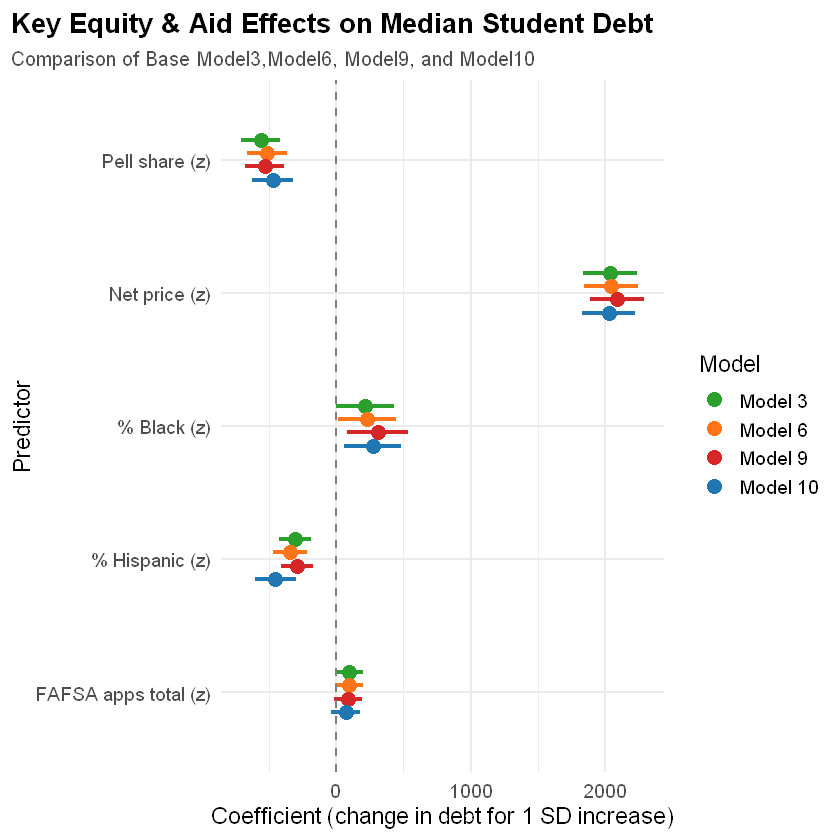

In [278]:
library(broom)
library(ggplot2)
library(dotwhisker)

# Keep only core predictors (drop intercept and year dummies)
keep_vars <- c("z_state_pell_share",
               "z_state_net_price",
               "z_pct_black",
               "z_pct_hispanic",
               "z_fafsa_apps_total")

dwplot(
  list("Model 10" = model10,
       "Model 9" = model9,
       "Model 6" = model6,
       "Model 3" = model3),
  vars_order = keep_vars,
  dot_args = list(size = 4),          # Slightly larger dots
  whisker_args = list(size = 1.2)     # Slightly thicker whiskers
) %>%
  relabel_predictors(c(
    z_state_pell_share    = "Pell share (z)",
    z_state_net_price     = "Net price (z)",
    z_pct_black           = "% Black (z)",
    z_pct_hispanic        = "% Hispanic (z)",
    z_fafsa_apps_total    = "FAFSA apps total (z)"
  )) +
  # --- Aesthetics Enhancements ---
  scale_color_manual(
    name = "Model",
    # Using a modern, distinct color palette (Deep Blue, Coral, and Mint)
    values = c("Model 10" = "#1F77B4", 
               "Model 9" = "#D62728", 
               "Model 6" = "#FF7518",
               "Model 3" = "#2CA02C") 
  ) +
  geom_vline(xintercept = 0, colour = "grey50", linetype = 2, size = 0.8) + 
  # --- Labels and Theme ---
  xlab("Coefficient (change in debt for 1 SD increase)") +
  ylab("Predictor") +
  ggtitle("Key Equity & Aid Effects on Median Student Debt",
          subtitle = "Comparison of Base Model3,Model6, Model9, and Model10") +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 16),
    plot.subtitle = element_text(size = 12, colour = "grey30"),
    legend.position = "right",
    # Center the plot title to ensure it has maximum horizontal space
    plot.title.position = "plot" 
  )


The coefficient plot  comparing the base model (Model 3) with the best-performing interaction models (Models 6, 9, and 10) confirms the robustness of the financial drivers while highlighting the strong sensitivity of the cost effect to racial demographics.
* Financial Drivers are Stable: The coefficients for Net Price(approx \\$2,000) and Pell Share (approx-\\$600) remain the largest and most consistent predictors across all models, confirming that cost increases debt and aid reduces it.
* The Cost Effect is Race-Dependent: The inclusion of the Net Price * % Hispanic interaction in Model 10 (the best fit) resulted in the largest negative shift in the Net Price coefficient (from approx\\$2,037 to approx \\$1,880 ). This demonstrates that the true, positive impact of college cost on debt is significantly moderated by the state's racial composition, specifically the Hispanic population share.
* Marginal Demographic Effects Remain: The coefficients for % Black (positive) and % Hispanic (negative) remain distinct and statistically relevant, regardless of which interaction term is included.

Thus, Model 10 represents the superior and most nuanced explanation: median student debt is driven by cost, but the magnitude of that cost-debt relationship is significantly conditional on the state's racial makeup.

#### 4. Prediction
**10-fold Cross-validaton**

In [301]:
set.seed(6414)
# Load necessary libraries (map and tibble for data handling)
library(dplyr)
library(purrr)
library(tibble)
library(modelr) # For crossv_kfold and add_predictions
library(caret) # For the trainControl parameters (though not strictly necessary here, keeps context)


# Use the filtered data frame (df_model3 / df_model2) used to fit M3-M10
data_for_cv <- df_model3 # Assumes df_model3 is available in your R environment


# Mean Squared Prediction Error (MSPE) / MSE.
mse_fun <- function(pred, dat) {
  mean((pred - dat)^2)
}
# Mean Absolute Prediction Error (MAE).
mae_fun <- function(pred, dat) {
  mean(abs(pred - dat))
}
# Mean Absolute Percentage Error (MAPE).
mape_fun <- function(pred, dat) {
  epsilon <- 1e-6 
  mean(abs(pred - dat) / abs(dat + epsilon))
}
# Precision Measure (PM) - Equivalent to 1 - R-squared (Relative MSE).
pm_fun <- function(pred, dat) {
  sum((pred - dat)^2) / sum((dat - mean(dat))^2)
}

# ---Define Model Formulas ( baseform is defined previously) ---
form_base <- baseform
form_pell_hispanic <- update(baseform, . ~ . + z_state_pell_share:z_pct_hispanic)
form_price_black <- update(baseform, . ~ . + z_state_net_price:z_pct_black)
form_price_hispanic <- update(baseform, . ~ . + z_state_net_price:z_pct_hispanic)

# List of models to iterate over
model_formulas <- list(
  Model3 = form_base,
  Model6 = form_pell_hispanic,
  Model9 = form_price_black,
  Model10 = form_price_hispanic
)

# --- Prediction and Measure Function for the loop ---
# Function to fit any given formula and calculate all 4 measures on the test set
get_pred_meas_custom <- function(formula, train_data, test_data) {
  test_df <- as.data.frame(test_data)
  
  # Fit the model on the training set
  model_fit <- lm(formula, data = train_data)
  
  # Predict and add predictions to the test data
  test_with_pred <- add_predictions(test_df, model_fit)
  
  # Calculate measures (actual is test_with_pred$grad_debt_mdn_w)
  measures <- c(
    MSE = mse_fun(test_with_pred$pred, test_with_pred$grad_debt_mdn_w),
    MAE = mae_fun(test_with_pred$pred, test_with_pred$grad_debt_mdn_w),
    MAPE = mape_fun(test_with_pred$pred, test_with_pred$grad_debt_mdn_w),
    PM = pm_fun(test_with_pred$pred, test_with_pred$grad_debt_mdn_w)
  )
  return(measures)
}

# --- Perform 10-Fold Cross-Validation ---
K <- 10
cv_folds <- crossv_kfold(data_for_cv, k = K)

# --- 6. Apply Accuarcy Measures to ALL Models ---
results_list <- list()

for (model_name in names(model_formulas)) {
  current_formula <- model_formulas[[model_name]]
  
  # Apply the custom function across all folds for the current model
  fold_measures <- map2(cv_folds$train, cv_folds$test, ~get_pred_meas_custom(current_formula, .x, .y))
  
  # Aggregate (mean) the measures across the 10 folds
  measures_matrix <- t(matrix(unlist(fold_measures), nrow = 4))
  mean_measures <- apply(measures_matrix, 2, mean)
  
  results_list[[model_name]] <- mean_measures
}

# --- 7. Final Comparison Table ---
final_metrics_table <- as.data.frame(do.call(rbind, results_list)) %>%
  rownames_to_column(var = "Model") %>%
  # *** RENAME COLUMNS HERE to match the vector names in the function ***
  rename(
    MSE = V1,
    MAE = V2,
    MAPE = V3,
    PM = V4
  ) %>%
  # Now 'MSE' exists, so the calculation works
  mutate(
    RMSE = sqrt(MSE)
  ) %>%
  arrange(RMSE) # Sort by best RMSE

cat("\n--- 10-Fold CV Prediction Metrics Comparison ---\n")
print(final_metrics_table)


--- 10-Fold CV Prediction Metrics Comparison ---
    Model      MSE      MAE       MAPE        PM     RMSE
1 Model10 568767.7 605.8322 0.05399506 0.1149070 754.1669
2  Model9 579400.3 614.6975 0.05504674 0.1167317 761.1835
3  Model6 580605.4 614.7380 0.05509418 0.1174052 761.9746
4  Model3 580661.1 619.6506 0.05548202 0.1170418 762.0112


Model 10 Dominates: Model 10 yields the lowest PM (0.115), the lowest RMSE, and the lowest MAE. Its predictive error variance is the smallest relative to the data's total variance.

Generalizability Confirmed: The results confirm that the interaction between College Cost (Net Price) and % Hispanic Population provides the most accurate and robust out-of-sample predictions.

Interaction Necessity: All interaction models (M10, M9, M6) achieved lower error rates than the Base Model (M3), validating the decision to analyze conditional effects.